Converting MACA Data for Envision and SWAT Models
============================

Evan Linde, Oklahoma State University, October 2017


# Introduction

This is a narrative of the process we followed to make data from the [MACAv2-METDATA](https://climate.northwestknowledge.net/MACA/MACAproducts.php#MACAproductcomparison) and [METDATA](https://climate.northwestknowledge.net/METDATA/) datasets usable in [Envision](http://envision.bioe.orst.edu/) and [SWAT](http://swat.tamu.edu/) models.

We attempt to provide clearly written code, commentary, and syntax explanation sufficient for someone with only introductory programming experience (e.g. like having attended a [Software Carpentry](https://software-carpentry.org/) workshop) to be able to follow and make use of the work shown here. The full explanation of a step or any command or code syntax we use should be found the first time we use it; later uses may contain shorter explanations or none at all. 

### Software

Software we used:
1. The netCDF library/binaries (the `ncdump` command)
1. [netCDF Operators](http://nco.sourceforge.net/)
1. [QGIS](http://www.qgis.org/)
1. `bash` (and common command line utilities)
1. `python` (specifically the [Anaconda](https://www.anaconda.com/) distribution)


All the steps shown can be performed on Windows, Linux/Unix, and Mac platforms. All the software and tools we used in this process are freely available. The `bash` shell, used for most of the scripting, is not native to Windows but is available in several software packages including [git](https://git-scm.com/), [Cygwin](https://www.cygwin.com/), and [MSYS2](http://www.msys2.org/).

### Acknowledgement and Disclaimer

Computation for this project was performed on TIGER, the research "cloud" at the Oklahoma State University [High Performance Computing Center](https://hpcc.okstate.edu/).

This material is based on work supported by the National Science Foundation under Grant No. [OIA-1301789](https://www.nsf.gov/awardsearch/showAward?AWD_ID=1301789). Any opinions, findings, and conclusions or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the National Science Foundation or Oklahoma State Regents for Higher Education.

# MACAv2-METDATA

## Downloading

Want to get:
* MACAv2-METDATA, daily, 2021-2099, rcps 4.5 and 8.5
* 9 Variables: tasmax, tasmin, rhsmax, rhsmin, huss, pr, rsds, uas, vas
* 2 RCPs: rcp45, rcp85
* 16 year blocks: 2021_2025, 2026_2030, 2031_2035, 2036_2040, 2041_2045, 2046_2050, 2051_2055, 2056_2060, 2061_2065, 2066_2070, 2071_2075, 2076_2080, 2081_2085, 2086_2090, 2091_2095, 2096_2099
* 20 models: bcc-csm1-1-m, bcc-csm1-1, BNU-ESM, CanESM2, CCSM4, CNRM-CM5, CSIRO-Mk3-6-0, GFDL-ESM2G, GFDL-ESM2M, HadGEM2-CC365, HadGEM2-ES365, inmcm4, IPSL-CM5A-LR, IPSL-CM5A-MR, IPSL-CM5B-LR, MIROC-ESM-CHEM, MIROC-ESM, MIROC5, MRI-CHCM3, NorESM1-M

Since we are interested in ultimately creating several different regional subsets we decided to download the full CONUS data and make our own subsets rather than task MACA's servers with this. The MACA data portal provides this link for direct file access: http://climate.nkn.uidaho.edu/MACAV2METDATA/MACAV2/.

Under this direct access link, we see a directory for each model and in each model directory, files named with a pattern like `macav2metdata_{variable}_{model}_r1i1p1_{rcp}_{year-block}_CONUS_daily.nc`. The files appear to be around 1GB to 2.5GB in size.

Since the files all seem to be predictably named, we create a bash script, `download.sh`, to automate the download process.


**`download.sh`**

```bash
#!/bin/bash
#
# Download netCDF files for MACAv2-METDATA
#

# Declare arrays for the models, year blocks, climate variables, and RCPs.
# These arrays will be used to build the URLs for the netCDF files we want
# to download.

MODELS=("bcc-csm1-1-m" "bcc-csm1-1" "BNU-ESM" "CanESM2" "CCSM4" "CNRM-CM5" 
    "CSIRO-Mk3-6-0" "GFDL-ESM2G" "GFDL-ESM2M" "HadGEM2-CC365" "HadGEM2-ES365" 
    "inmcm4" "IPSL-CM5A-LR" "IPSL-CM5A-MR" "IPSL-CM5B-LR" "MIROC-ESM-CHEM" 
    "MIROC-ESM" "MIROC5" "MRI-CGCM3" "NorESM1-M")

YEAR_BLOCKS=("2021_2025" "2026_2030" "2031_2035" "2036_2040" "2041_2045" 
    "2046_2050" "2051_2055" "2056_2060" "2061_2065" "2066_2070" "2071_2075" 
    "2076_2080" "2081_2085" "2086_2090" "2091_2095" "2096_2099")

VARS=("tasmax" "tasmin" "rhsmax" "rhsmin" "huss" "pr" "rsds" "uas" "vas")

RCPS=("rcp45" "rcp85")

# Beginning part of all the URLs we want
base_url="https://climate.northwestknowledge.net/MACAV2METDATA/MACAV2"

echo "Begin: $(date)"

for model in ${MODELS[@]}; do

    echo "Start downloading model ${model} $(date)"
    mkdir -p "${model}"

    # Go into each model directory to download files for that model. 
    # We can get back to our current directory later with the popd command.
    pushd "${model}"

    for wvar in ${VARS[@]}; do

        for block in ${YEAR_BLOCKS[@]}; do

            for rcp in ${RCPS[@]}; do

                # Build the URL we want to download using all the array 
                # variables that we're looping over.
                # First generate the filename
                filename="macav2metdata_${wvar}_${model}_r1i1p1_${rcp}_${block}_CONUS_daily.nc"
                # Then the full URL
                url="${base_url}/${model}/${filename}"

                # Start the download process backgrounded so we don't have to 
                # wait for it to finish before the next one starts.
                wget ${url} &

            done   # end rcp loop

            # Wait for backgrounded processes to finish so that we're not
            # trying to download ALL the files at once. We're doing this just
            # outside the rcp loop so that we only download two (length of 
            # RCPS array) files at a time.
            wait  

        done  # end year block loop

    done  # end wvar loop

    # Go back to the directory we were working in when we ran pushd earlier
    popd
    echo "Finish downloading model ${model} $(date)"

done  # end model loop

echo "End: $(date)"
```

The bash script has some extra output to give us some idea of how long everything takes.

The download process is expected to take a while (we're downloading 5760 files totalling over 10 TB) and we will be starting the script on TIGER's data transfer node (which won't be slowed down by the campus firewall). So we start the download script from within a `screen` session so that it won't be killed if the ssh session is interrupted.

```bash
bash download.sh | tee -a download.log
```

Partway through the download process, we noticed that the directory for the CCSM4 model was empty. Upon further investigation, we noticed that the files under this model use the string "r6i1p1" instead of "r1i1p1" in their file names. So we made a second download script, `download2.sh`, to finish these files.

**`download2.sh`**

```bash
#!/bin/bash
#
# Download just the CCSM4 model from MACAv2-METDATA
#

MODELS=("CCSM4")
YEAR_BLOCKS=("2021_2025" "2026_2030" "2031_2035" "2036_2040" "2041_2045" 
    "2046_2050" "2051_2055" "2056_2060" "2061_2065" "2066_2070" "2071_2075" 
    "2076_2080" "2081_2085" "2086_2090" "2091_2095" "2096_2099")
VARS=("tasmax" "tasmin" "rhsmax" "rhsmin" "huss" "pr" "rsds" "uas" "vas")
RCPS=("rcp45" "rcp85")

base_url="https://climate.northwestknowledge.net/MACAV2METDATA/MACAV2"

echo "Begin: $(date)"
for model in ${MODELS[@]}; do
    mkdir -p "${model}"
    pushd "${model}"
    for wvar in ${VARS[@]}; do
        for block in ${YEAR_BLOCKS[@]}; do
            for rcp in ${RCPS[@]}; do
                filename="macav2metdata_${wvar}_${model}_r6i1p1_${rcp}_${block}_CONUS_daily.nc"
                url="${base_url}/${model}/${filename}"
                wget ${url} &
            done
            wait
        done
    done
    popd
done
echo "End: $(date)"
```

Similarly, we start the `download2.sh` script in a `screen` session to finish the download.

```bash
bash download2.sh | tee -a download2.log
```

The main download script also missed another model due to a typo. We corrected the type in the download script then also created a copy similar to `download2.sh` to download only the model that we missed.

The main download script downloaded 16 of the 18 models in just over two days:
```
Begin: Mon Sep 25 15:58:35 CDT 2017
End: Wed Sep 27 18:39:49 CDT 2017
```

The second download script (CCSM4) completed in about 1.5 hours:
```
Begin: Wed Sep 27 19:08:32 CDT 2017
End: Wed Sep 27 20:36:38 CDT 2017
```

After completing the downloads, we noticed that two models do not have the variables "rhsmax" and "rhsmin".

These models are:
1. CCSM4
2. NorESM1-M

This is actually noted in the MACA documentation at https://climate.northwestknowledge.net/MACA/GCMs.php.

## Examining the Data

Some very informative information about the MACAv2-METDATA dataset can be found at
https://climate.northwestknowledge.net/MACA/MACAproducts.php#MACAproductcomparison, but we'll need more detail than this for creating watershed subsets and converting data for use with our models.

### ncdump

The `ncdump` command is a utility associated with the netCDF library. It is available from [Unidata](http://www.unidata.ucar.edu/) at https://www.unidata.ucar.edu/downloads/netcdf/index.jsp in the form of source code or Windows binary. It is available via the package manager in many Linux distributions under either `netcdf` or `netcdf-bin`. 

Note:

> A version of `ncdump` may also be installed by `conda` if you've used `conda` to download netCDF libraries for python. The `conda`-installed version seems to be a bit finnicky, sometimes giving errors like `*** ncdump: ncopen failed on ${filename}` where the regular version has no problems. 

> If you run into an error like this you can use the command `which -a` to see all the instances of `ncdump` in your `PATH`; the first line of the results is the full path to the default `ncdump` command. You can call another instance of `ncdump` by using its full path (e.g. `/usr/bin/ncdump`). You can avoid having to do this by creating an alias or editing your `PATH` variable, however these are beyond the scope of this document.

### Viewing Headers and Metadata

We can view a netCDF file's header with a command like this:
```bash
ncdump -h file.nc
```

Other options like `-c` or `-v variable` are useful for dumping coordinate information or values for a specific variable and these also include the header, but the option for the header alone, `-h`, is the most best way to get useful information without a lot of extra clutter. (The command form `ncdump file.nc` will dump the entire contents to your screen; you really don't want to do this with a large file.)

Here's a literal example:
```bash
ncdump -h CCSM4/macav2metdata_huss_CCSM4_r6i1p1_rcp45_2021_2025_CONUS_daily.nc
```

And the output, i.e. the file's header / metadata:

```
netcdf macav2metdata_huss_CCSM4_r6i1p1_rcp45_2021_2025_CONUS_daily {
dimensions:
	lat = 585 ;
	lon = 1386 ;
	time = 1826 ;
	crs = 1 ;
variables:
	double lat(lat) ;
		lat:long_name = "latitude" ;
		lat:standard_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:description = "Latitude of the center of the grid cell" ;
	double lon(lon) ;
		lon:long_name = "longitude" ;
		lon:standard_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:description = "Longitude of the center of the grid cell" ;
	float time(time) ;
		time:units = "days since 1900-01-01 00:00:00" ;
		time:calendar = "gregorian" ;
		time:description = "days since 1900-01-01" ;
	float specific_humidity(time, lat, lon) ;
		specific_humidity:_FillValue = -9999.f ;
		specific_humidity:long_name = "Daily Mean Near-Surface Specific Humidity" ;
		specific_humidity:units = "kg kg-1" ;
		specific_humidity:grid_mapping = "crs" ;
		specific_humidity:standard_name = "specific_humidity" ;
		specific_humidity:height = "0 m" ;
		specific_humidity:cell_methods = "time: mean(interval: 24 hours)" ;
		specific_humidity:comments = "Surface specific humidity" ;
		specific_humidity:coordinates = "time lon lat" ;
	int crs(crs) ;
		crs:grid_mapping_name = "latitude_longitude" ;
		crs:longitude_of_prime_meridian = 0. ;
		crs:semi_major_axis = 6378137. ;
		crs:inverse_flattening = 298.257223563 ;

// global attributes:
		:description = "Multivariate Adaptive Constructed Analogs (MACA) method, version 2.3,Dec 2013." ;
		:id = "MACAv2-METDATA" ;
		:naming_authority = "edu.uidaho.reacch" ;
		:Metadata_Conventions = "Unidata Dataset Discovery v1.0" ;
		:Metadata_Link = "" ;
		:cdm_data_type = "GRID" ;
		:title = "Downscaled daily meteorological data of Daily Mean Near-Surface Specific Humidity from University of Miami - RSMAS (CCSM4) using the run r6i1p1 of the rcp45 scenario." ;
		:summary = "This archive contains daily downscaled meteorological and hydrological projections for the Conterminous United States at 1/24-deg resolution utilizing the Multivariate Adaptive Constructed Analogs (MACA, Abatzoglou, 2012) statistical downscaling method with the METDATA (Abatzoglou,2013) training dataset. The downscaled meteorological variables are maximum/minimum temperature(tasmax/tasmin), maximum/minimum relative humidity (rhsmax/rhsmin)precipitation amount(pr), downward shortwave solar radiation(rsds), eastward wind(uas), northward wind(vas), and specific humidity(huss). The downscaling is based on the 365-day model outputs from different global climate models (GCMs) from Phase 5 of the Coupled Model Inter-comparison Project (CMIP3) utlizing the historical (1950-2005) and future RCP4.5/8.5(2006-2099) scenarios. Leap days have been added to the dataset from the average values between Feb 28 and Mar 1 in order to aid modellers." ;
		:keywords = "daily precipitation, daily maximum temperature, daily minimum temperature, daily downward shortwave solar radiation, daily specific humidity, daily wind velocity, CMIP5, Gridded Meteorological Data" ;
		:keywords_vocabulary = "" ;
		:standard_name_vocabulary = "CF-1.0" ;
		:history = "No revisions." ;
		:comment = "Surface specific humidity" ;
		:geospatial_bounds = "POLYGON((-124.7722 25.0631,-124.7722 49.3960, -67.0648 49.3960,-67.0648, 25.0631, -124.7722,25.0631))" ;
		:geospatial_lat_min = "25.0631" ;
		:geospatial_lat_max = "49.3960" ;
		:geospatial_lon_min = "-124.7722" ;
		:geospatial_lon_max = "-67.0648" ;
		:geospatial_lat_units = "decimal degrees north" ;
		:geospatial_lon_units = "decimal degrees east" ;
		:geospatial_lat_resolution = "0.0417" ;
		:geospatial_lon_resolution = "0.0417" ;
		:geospatial_vertical_min = 0. ;
		:geospatial_vertical_max = 0. ;
		:geospatial_vertical_resolution = 0. ;
		:geospatial_vertical_positive = "up" ;
		:time_coverage_start = "2021-01-01T00:0" ;
		:time_coverage_end = "2025-12-31T00:00" ;
		:time_coverage_duration = "P5Y" ;
		:time_coverage_resolution = "P1D" ;
		:date_created = "2014-05-15" ;
		:date_modified = "2014-05-15" ;
		:date_issued = "2014-05-15" ;
		:creator_name = "John Abatzoglou" ;
		:creator_url = "http://maca.northwestknowledge.net" ;
		:creator_email = "jabatzoglou@uidaho.edu" ;
		:institution = "University of Idaho" ;
		:processing_level = "GRID" ;
		:project = "" ;
		:contributor_name = "Katherine C. Hegewisch" ;
		:contributor_role = "Postdoctoral Fellow" ;
		:publisher_name = "" ;
		:publisher_email = "" ;
		:publisher_url = "" ;
		:license = "Creative Commons CC0 1.0 Universal Dedication(http://creativecommons.org/publicdomain/zero/1.0/legalcode)" ;
		:coordinate_system = "WGS84,EPSG:4326" ;
}
```


The parts of the header most relevant to our tasks are the `dimensions` and `variables` sections (i.e. everything before the line starting with `// global attributes` in the example above). 

Each variable definition includes several metadata fields describing the variable data.

### Viewing Coordinate Data

We can view coordinate data (in the case of MACAv2-METDATA: latitude, longitude, and time) by calling ncdump with the `-c` flag.

```bash
ncdump -c CCSM4/macav2metdata_huss_CCSM4_r6i1p1_rcp45_2021_2025_CONUS_daily.nc
```

Here's the output showing the first and last parts of each coordinate variable. (Everything else is ellipsized.)
```
...
 lat = 25.0630779266357, 25.1047439575195, 25.1464099884033, 
...
    49.3543586730957, 49.3960227966309 ;

 lon = 235.227844238281, 235.269500732422, 235.311157226562, 
...
    292.851928710938, 292.893585205078, 292.935241699219 ;

 time = 44195, 44196, 44197, 44198, 44199, 44200, 44201, 44202, 44203, 44204, 
...
    46015, 46016, 46017, 46018, 46019, 46020 ;
...
```




Note how the time values don't look like dates or times. This can be explained by looking back at the `time` definition from the header:
```
    float time(time) ;
        time:units = "days since 1900-01-01 00:00:00" ;
        time:calendar = "gregorian" ;
        time:description = "days since 1900-01-01" ;
```
Since this file is for 2021-2025, the lowest time value, 44195, should be for January 1, 2021. We can verify this by calculating the date 44195 days since 1900-01-01 with the GNU `date` command:
```bash
date --date="1900-01-01 +44195 days"
```
And we get the result: 
```
Fri Jan  1 00:00:00 CST 2021
```

Also, we see something important about the longitude values. The metadata for the `lon` variable shows `lon:units = "degrees_east"`. Valid values could be either -180 to +180 (e.g. 90&deg;W = -90) or 0 to 360 (e.g. 90&deg;W = 270). Which valid range is being used is not specified in the header, but since we see values greater than 180, the files must be using the 0-360 range.


Note that the coordinate variables correspond to the dimensions of the file and that they appear in the definition of record variables:
```
float specific_humidity(time, lat, lon) ;
```

### Viewing Variable Data

We can view variable data by calling `ncdump` with the command option `-v variablename`. This is especially useful for (one-dimensional) coordinate variables, where we get a series of ordered values (usually in increasing order).

```bash
ncdump -v lat CCSM4/macav2metdata_huss_CCSM4_r6i1p1_rcp45_2021_2025_CONUS_daily.nc
```

Here's the output showing the first and last parts of the variable. (Everything else is ellipsized.)
```
...
 lat = 25.0630779266357, 25.1047439575195, 25.1464099884033,
...
    49.3543586730957, 49.3960227966309 ;
}
```

We can also pipe the output to other commands to filter and transform it into something more useful.

Here we filter out the header and any remaining lines after the end of the latitude data:
```bash
ncdump -c CCSM4/macav2metdata_huss_CCSM4_r6i1p1_rcp45_2021_2025_CONUS_daily.nc | sed -n '/^ lat =/,/;/p'
```

Here are the results (with most of the latitude data ellipsized):
```
 lat = 25.0630779266357, 25.1047439575195, 25.1464099884033, 
...
    49.3543586730957, 49.3960227966309 ;
```

Explanation:
> The `-n` flag tells the `sed` command not to print lines by default. Then in the script that we give to the `sed` command, `/^ lat =/,/;/p`, we tell it to print lines starting from where it finds the pattern `^ lat =` (" lat =" at the beginning of a line) through the first line where it finds a semicolon. The syntax here is `address command` but without spaces and in this case the address is a range in the form of `start,end`. More info can be found under the topic [Addresses](https://www.gnu.org/software/sed/manual/sed.html#sed-addresses) in the `sed` manual.


Here we take the previous command a step further and format the data into one record per line: 
```bash
ncdump -c CCSM4/macav2metdata_huss_CCSM4_r6i1p1_rcp45_2021_2025_CONUS_daily.nc | sed -n '/^ lat =/,/\;/{s/ *lat = *//g;p}' | tr -d '\n ' | tr ',;' '\n\n'
```

And the output looks like this (with all the middle values ellipsized):
```
25.0630779266357
25.1047439575195
...
49.3543586730957
49.3960227966309
```

Explanation:
> Instead of just printing like in the previous command, we're telling `sed` to get rid of the "lat =" part and any surrounding spaces, then print. Then we're sending the output to the `tr` command to delete all line breaks and spaces. At this point the output would look like like a single line of numbers with commas between them and a semicolon at the end; this output is sent to another `tr` command to change the commas and semicolon into line breaks, giving us one number on each line.

This can be generalized so that it's easy to use a different variable:
```bash
v="lat"
ncdump -v $v somefile.nc | sed -n '/^ '"$v"' =/,/\;/{s/ *'"$v"' = *//g;p}' | tr -d '\n ' | tr ',;' '\n\n'
```

And to view just the first and last values we could take a slightly different approach:
```bash
v="lat"
ncdump -v $v somefile.nc | sed -n '/^ '"$v"' = /,/;/p' | tr -d '\n' | awk '{print $3,$(NF-1)}'
```

Explanation:

> Here we're going back to just using `sed` to only filter out the lines before and avter our variable, then we're using `tr` to delete all the line breaks, giving us everything on a single line. Then we're telling `awk` to print the third and next-to-last fields of its input. 

>Since `awk` splits the input into fields using whitespace by default, the first field, `$1`, will be `lat`, the second field will be `=`, and the third field will be the first actual value; since there's a space between the last value and the semicolon at the end, the last field, `$NF`, will be `;` and since `NF` is a variable representing a number we can subtract one to get the previous field.

## Subsetting

To make some of the steps easier, we're going to make a list of all the netcdf files which we can use instead of the loops from earlier which didn't handle a few minor things.

To make the list, we go to the download directory (which contains a directory for each model) and run the following command in bash:
```bash
find ./ -mindepth 2 -name '*.nc' | sed 's/^\.\///g' > file_list.txt
```

Explanation:

> In the first part of this command, `find ./ -mindepth 2 -name '*.nc'`, we're specifying that we want to find files with names ending with `.nc` and that we want to look for them in subfolders of the current directory, `./`. (Files in the current directory, e.g `somefile.nc` are at depth 1.) The output from `find` looks like this:
```
./bcc-csm1-1-m/macav2metdata_tasmax_bcc-csm1-1-m_r1i1p1_rcp45_2021_2025_CONUS_daily.nc
./bcc-csm1-1-m/macav2metdata_tasmax_bcc-csm1-1-m_r1i1p1_rcp85_2021_2025_CONUS_daily.nc
./bcc-csm1-1-m/macav2metdata_tasmax_bcc-csm1-1-m_r1i1p1_rcp85_2026_2030_CONUS_daily.nc
...
```
    
> Between the first and second parts of the command we have a pipe, `|`, to make the output from `find` be input for `sed`.

> In the second part of the command, `sed 's/^\.\///g'`, we're removing `./` from the beginning of every line of output from the `find` command. The output from `sed` looks like this:
```
bcc-csm1-1-m/macav2metdata_tasmax_bcc-csm1-1-m_r1i1p1_rcp45_2021_2025_CONUS_daily.nc
bcc-csm1-1-m/macav2metdata_tasmax_bcc-csm1-1-m_r1i1p1_rcp85_2021_2025_CONUS_daily.nc
bcc-csm1-1-m/macav2metdata_tasmax_bcc-csm1-1-m_r1i1p1_rcp85_2026_2030_CONUS_daily.nc
...
```
    
> Finally, with the `> file_list.txt` part, we're redirecting the output from the `sed` command into a file instead of having it appear on screen. The output redirection we've done here, `>` will cause anything already in `file_list.txt`, if it already exists, to be deleted. If we didn't want to overwrite existing data, we would use `>>` to *append* to an existing file. Both `>` and `>>` will create the target file if it doesn't exist.


We can create geographical subsets of netCDF files using the [netCDF Operators](http://nco.sourceforge.net/) (NCO). NCO is available pre-compiled for Windows and Mac and available via the package manager in many Linux distributions; source code is also available if you prefer to compile everything yourself. 

NCO has several different commands with a lot of common functionality among them. For our geographical subsets, we'll be using the `ncks` (netCDF Kitchen Sink) command.

The generic command form to greate a geographic subset of the MACAv2 netcdf files is like this:
```
ncks -d lat,min_value,max_value -d lon,min_value,max_value infile.nc outfile.nc
```

In this command, we're creating a [hyperslab](http://nco.sourceforge.net/nco.html#Hyperslabs) (our geographical subset) of the data in `infile.nc` using the *dimensions* `lat` and `lon` and writing it to the output file `outfile.nc`. We know that `lat` and `lon` are the dimension names we want to use from having looked at the file headers with `ncdump`.

### Cimarron

To create the subsets for the Cimarron watershed, we first need to find the latitude and longitude ranges we need to cover.

We can do this in either QGIS or ArcGIS by opening the shapefile and looking at the extents.

Here are the directions for QGIS:
1. Layer menu --> Add Layer --> Add Vector Layer
1. Browse and select the appropriate shapefile (.shp)
1. Layer menu --> Properties
1. On the Metadata tab, expand the Properties section and look for Extents

This is what we see:
```
xMin,yMin -100.119,35.3783 : xMax,yMax -95.9538,37.3697
```

The bounds of the Cimarron watershed shape:
* N bound: 37.3697&deg;
* S bound: 35.3783&deg;
* E bound: -95.9538&deg;
* W bound: -100.119&deg;

To find the latitude and longitude values we'll use to encompass the watershed shape, we dump the coordinate values from one of the files using the `ncdump` command:
```bash
ncdump -c CCSM4/macav2metdata_tasmax_CCSM4_r6i1p1_rcp85_2096_2099_CONUS_daily.nc
```

From this command's output, we select the first value higher than the North and East bounds and the first value lower than the South and West bounds to use for our subset.

The longitude coordinates are in degrees east (just like our shapefile's extent coordinates), but unlike our shapefile, the netCDF file uses positive values (180 ... 360) for the Western hemisphere instead of negative values (-180 ... 0). So we'll need to add 360 to our longitude values to get the correct positive values.
* E bound: -95.9538&deg; = 264.0462&deg;
* W bound: -100.119&deg; = 259.881&deg;


The coordinates we'll use for our Cimarron subset are:
* N bound: 37.3962135314941&deg; 
* S bound: 35.3545799255371&deg;
* E bound: 264.060699462891&deg;
* W bound: 259.852447509766&deg;

So the command to create a subset covering the Cimarron watershed (in netCDF 3 classic format) will look like this:
```bash
ncks -3 -d lat,35.3545799255371,37.3962135314941 -d lon,259.852447509766,264.060699462891 infile.nc outfile.nc
```

After creating a subset using these latitude and longitude coordinates, we noticed that the end points were not necessarily included like they should be. (This actually came to our attention with Kiamichi, where the lack of the easternmost column of raster cells caused the shapefile to be not completely covered. We then confirmed the same issue with the Cimarron subsets. Our best guess is that this has something to do with floating point error.) The files created with the above command only included latitudes 35.3545799255371 - *37.354549407959* and longitudes *259.894104003906* - 264.060699462891.

Note, for the North boundary, 37.354549407959 actually works because the coordinates are for the center of the grid cell and 37.369727 is *less* than halfway between 37.354549407959 and 37.3962135314941.

Similarly, for the West boundary, 259.894104003906 works because 259.881479 is *more* than halfway between 259.852447509766 and 259.894104003906.

So it was not necessary to revise this command. 

However, we *should* revise our criteria for selecting coordinates from the netCDF file. The file header specifies that latitude and longitude coordinates are for the center of the grid cells; this means that the grid cell closest to a point "covers" that point. So we'll want to select the values *closest* to our shapefile's bounds to use for our subset.

Here is the Cimarron shape shown over the subset area. Note that the Southernmost row of cells is completely outside the shapefile's extent.

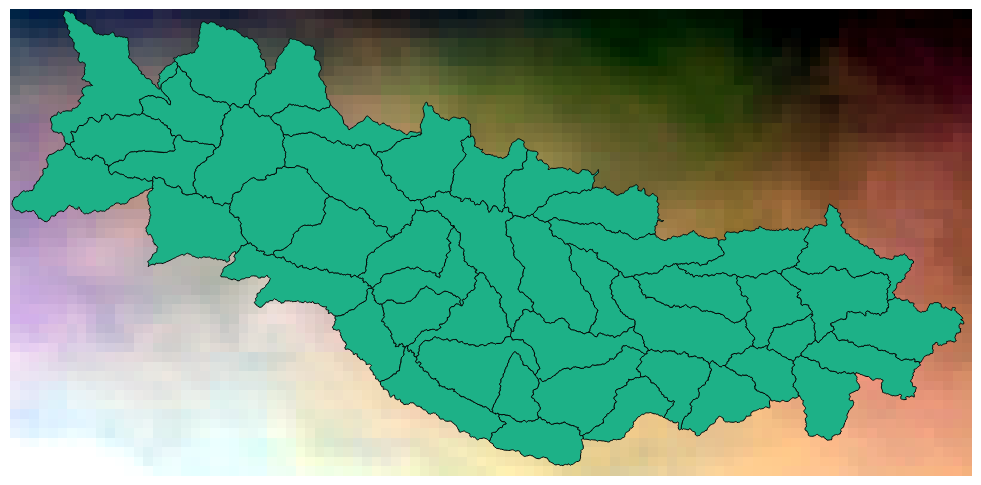

Now that we've confirmed that our shapefile is completely within the subset area, we're ready to make subsets of all the files.

Create a new directory outside of the download directory called "MACAv2_Derived".
```bash
mkdir ../MACAv2_Derived
```

Create parent directories for all the Cimarron subset files:
```bash
mkdir -p ../MACAv2_Derived/Cimarron/{bcc-csm1-1-m,bcc-csm1-1,BNU-ESM,CanESM2,CCSM4,CNRM-CM5,CSIRO-Mk3-6-0,GFDL-ESM2G,GFDL-ESM2M,HadGEM2-CC365,HadGEM2-ES365,inmcm4,IPSL-CM5A-LR,IPSL-CM5A-MR,IPSL-CM5B-LR,MIROC-ESM-CHEM,MIROC-ESM,MIROC5,MRI-CGCM3,NorESM1-M}
```

Explanation:
> The syntax used in the `mkdir` command is explained in the `bash` manual under the topic [Brace Expansion](https://www.gnu.org/software/bash/manual/html_node/Brace-Expansion.html). To explain with an example: the command `mkdir bl{a,e,i,o,u}h` would be expanded to `mkdir blah bleh blih bloh bluh`. Bash itself expands the expression with the curly braces before the `mkdir` command does anything.


Create the Cimarron subset files:
```bash
for f in $(cat file_list.txt); do 
    ncks -3 -d lat,35.3545799255371,37.3962135314941 -d lon,259.852447509766,264.060699462891 ${f} ../MACAv2_Derived/Cimarron/${f/CONUS/Cimarron}; 
done
```

Explanation:
> Each line of the file `file_list` identifies one of the netCDF files using a relative path in the form of *model*/*filename*. Here, we're using a [`for` loop](https://www.gnu.org/software/bash/manual/html_node/Looping-Constructs.html) to repeat our `ncks` subset command for every netCDF file in the list. (Note that this wouldn't work correctly if any of the filenames or model directories had spaces.)

> `$(cat file_list.txt)` This syntax is explained in the `bash` manual under the topic [Command Substitution](https://www.gnu.org/software/bash/manual/html_node/Command-Substitution.html).

> `${f/CONUS/Cimarron}` is the variable `${f}` with the substring "CONUS" replaced with "Cimarron". This syntax (and other similar functionality) is defined in the `bash` manual under the topic [Shell Parameter Expansion](https://www.gnu.org/software/bash/manual/html_node/Shell-Parameter-Expansion.html).

Creating the Cimarron subset took about 7.5 hours (with the Kiamichi subset running concurrently for about 3.33 hours, and the Kiamichi data conversion running concurrently for about 1.75 hours). The size of the Cimarron subset is about 188 GB.

### Kiamichi

To create the subsets for the Kiamichi watershed, we first need to find the latitude and longitude ranges we need to cover.

We do this in QGIS by opening the shapefile and looking at the extents. Here are the steps:
1. Layer menu --> Add Layer --> Add Vector Layer
1. Browse and select the appropriate shapefile (.shp)
1. Layer menu --> Properties
1. On the Metadata tab, expand the Properties section and look for Extents

This is what we see:
```
xMin,yMin -95.8222,33.9145 : xMax,yMax -94.456,34.8217
```

The bounds of the Kiamichi watershed shape:
* N bound: 34.8217&deg;
* S bound: 33.9145&deg;
* E bound: -94.456&deg; = 265.544&deg;
* W bound: -95.8222&deg; = 264.1778&deg;

The longitude coordinates in the netCDF files have positive values (180 ... 360) for the Western hemisphere, so we added 360 to our longitude value to match the files' scheme.

We find the latitude and longitude values which will encompass the watershed shape by using the `ncdump` command on one of the files:
```bash
ncdump -c CCSM4/macav2metdata_tasmax_CCSM4_r6i1p1_rcp85_2096_2099_CONUS_daily.nc
```

We select our boundary coordinates by finding the next Northern and Eastern values higher than the shapefile bounds and the next Southern and Western values lower than the shapefile bounds.

For Kiamichi these are:
* N bound: 34.8545875549316
* S bound: 33.8962707519531
* E bound: 265.560668945312
* W bound: 264.14404296875

So the command to create a subset covering the Kiamichi watershed (in netCDF 3 classic format) will look like this:
```bash
ncks -3 -d lat,33.8962707519531,34.8545875549316 -d lon,264.14404296875,265.560668945312 infile.nc outfile.nc
```

After creating a subset using these latitude and longitude coordinates, we noticed that the end points were not necessarily included like they should be. (Our best guess is that this has something to do with floating point error.) So the files created with the above command only included latitudes 33.8962707519531 - *34.8129234313965* and longitudes 264.14404296875 - *265.519012451172*.

For the North boundary, 34.8129234313965 works because the coordinates are for the center of the grid cell and 34.821695 is *less* than halfway between 34.8129234313965 and 34.8545875549316.

However, the easternmost point, 265.543970, is *more* than halfway between 265.519012451172 and 265.560668945312, meaning it is outside the area covered by the raster. Therefore we need to revise our subset command.

The next longitude coordinate is 265.602355957031. So the *revised* command to create a subset covering the Kiamichi watershed (in netCDF 3 classic format) will look like this:

```bash
ncks -3 -d lat,33.8962707519531,34.8545875549316 -d lon,264.14404296875,265.602355957031 infile.nc outfile.nc
```


As noted above in the Cimarron section (we were working on both watershed areas more-or-less simultaneously) we need to revise our criteria for selecting boundary points from the netCDF files. We want to use the values *closest* to our shapefile's bounds to use for our subset.

Here is the Kiamichi shape shown over the subset area. Note that that the Westernmost column of cells is completely outside the shapefile's extent.

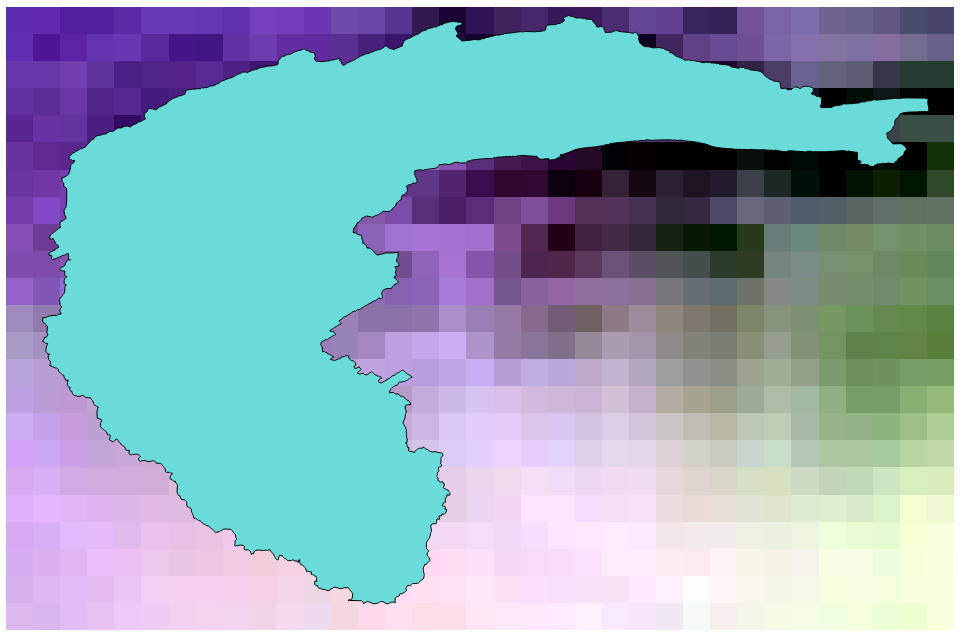

In the "MACAv2_Derived" directory, create parent directories for all the Kiamichi subset files:
```bash
mkdir -p ../MACAv2_Derived/Kiamichi/{bcc-csm1-1-m,bcc-csm1-1,BNU-ESM,CanESM2,CCSM4,CNRM-CM5,CSIRO-Mk3-6-0,GFDL-ESM2G,GFDL-ESM2M,HadGEM2-CC365,HadGEM2-ES365,inmcm4,IPSL-CM5A-LR,IPSL-CM5A-MR,IPSL-CM5B-LR,MIROC-ESM-CHEM,MIROC-ESM,MIROC5,MRI-CGCM3,NorESM1-M}
```

Explanation:
> See the topic [Brace Expansion](https://www.gnu.org/software/bash/manual/html_node/Brace-Expansion.html) in the `bash` manual for an explanation of the syntax used here.

Create the Kiamichi subset files:
```bash
for f in $(cat file_list.txt); do 
    ncks -3 -d lat,33.8962707519531,34.8545875549316 -d lon,264.14404296875,265.602355957031 ${f} ../MACAv2_Derived/Kiamichi/${f/CONUS/Kiamichi}; 
done
```

Explanation:
> Here we're using a `for` loop to run our `ncks` subset command on all the files. See the topics [Looping Constructs](https://www.gnu.org/software/bash/manual/html_node/Looping-Constructs.html), [Command Substitution](https://www.gnu.org/software/bash/manual/html_node/Command-Substitution.html), and [Shell Parameter Expansion](https://www.gnu.org/software/bash/manual/html_node/Shell-Parameter-Expansion.html) in the `bash` manual for explanation of all the syntax used here.

Creating the Kiamichi subset took about 3.33 hours (running concurrently with the Cimarron subset). The size of the Kiamichi subset is about 31 GB.

## Converting for Envision Models

For our Envision models, these are the variables that we'll need:

Variable | Units
---------|--------
maximum temperature | &deg;C
minimum temperature | &deg;C
mean temperature | &deg;C
solar radiation | W m$^{-2}$
specific humidity | kg kg$^{-1}$
wind speed | m s$^{-1}$
precipitation | mm day$^{-1}$

The MACAv2-METDATA dataset has all of these except for mean temperature and wind speed, but we can derive them from the provided variables.

From examining the header data for one of each variable's netCDF files, we can see that we'll need to do some unit conversion on the temperature variables; other than those, everything is already in the units we want. (The wind *vectors* which we'll use to derive wind speed are also in our desired units.)

Before we started, we knew that there was some sort of compatibility issue between the MACAv2 netCDF files and Envision. The MACA data portal mentions that the [MACAv2 files are in netCDF4 format](https://climate.northwestknowledge.net/MACA/data_portal.php#issuesNetCDFTab), so we assumed (correctly!) that gdal library Envision uses required netCDF 3 (classic) format. Conveniently all the netCDF operators seem to have the same options for setting output format, so all we have to do to convert everything to netCDF 3 is add the `-3` flag to one of our processing commands.

After a bit of testing we determined that Envision couldn't handle MACAv2's longitude coordinates > 180&deg; for the Western hemisphere, so every variable we want to use with Envision needs at least the longitude converted.

So here are the conversions we need to perform:

1. Change longitude > 180&deg; to negative values (i.e. subtract 360)
1. Change *tasmax* units from &deg;K to &deg;C (i.e. subtract 273.15)
1. Change *tasmin* units from &deg;K to &deg;C
1. Create variable for mean temperature (average of tasmax and tasmin in &deg;C)
1. Create variable for wind speed based on Northward and Eastward wind vectors (*uas* and *vas*)

In addition to unit and coordinate conversions and the new variables we need to derive, Envision also wants *yearly* files.

### General Procedures

Here are generic forms of all our conversion procedures. Where any of our changes make the existing metadata invalid we're also updating the metadata to be correct.

**Longitude conversion**

Convert positive longitude values > 180&deg; to negative values. E.g. 265&deg;E (95&deg;W) = -95. All we have to do here is subtract 360 from all the longitude coordinates since all our coordinates are in the Western hemisphere. 

Use [`ncap2`](http://nco.sourceforge.net/nco.html#ncap2), the netCDF Arithmetic Processor, for this step.

```
ncap -s 'lon=lon-360' infile.nc outfile.nc
```

**Temperature conversion**

Convert Kelvins to degrees Celsius. We can use `ncap2` for the actual data conversion since the conversion from Kelvins to Celsius is simply arithmetic (subtracting 273.15) just like we used in converting the longitude coordinates, but then we'll want to update the metadata so that we won't be misled if we look at things later.

Before updating the metadata, this is what we see for the `air_temperature` variable:
```
	float air_temperature(time, lat, lon) ;
		air_temperature:_FillValue = -9999.f ;
		air_temperature:long_name = "Daily Maximum Near-Surface Air Temperature" ;
		air_temperature:units = "K" ;
		air_temperature:grid_mapping = "crs" ;
		air_temperature:standard_name = "air_temperature" ;
		air_temperature:height = "2 m" ;
		air_temperature:cell_methods = "time: maximum(interval: 24 hours)" ;
		air_temperature:coordinates = "time lon lat" ;
```

Since we're converting to Celsius, we want to change the `units` attribute to `C` instead of `K`.

We can do this with [`ncatted`](http://nco.sourceforge.net/nco.html#ncatted), the netCDF Attribute Editor. In NCO terminology, we want to overwrite (`o`) the `units` attribute (`-a`) of the `air_temperature` variable; the datatype for the `units` attribute is `char` (`c`) and the value we want to give to it is `'C'`.

Unlike most of the NCO commands, `ncatted` can usually edit a file in place and will do this if only given one filename.

So our `ncatted` command looks like this:
```
ncatted -a units,air_temperature,o,c,'C' testfile.nc
```

After running this command we look at the `air_temperature` variable again and see that our command was successful (and that the attributes are now arranged in alphabetical order).
```
	float air_temperature(time, lat, lon) ;
		air_temperature:_FillValue = -9999.f ;
		air_temperature:cell_methods = "time: maximum(interval: 24 hours)" ;
		air_temperature:coordinates = "time lon lat" ;
		air_temperature:grid_mapping = "crs" ;
		air_temperature:height = "2 m" ;
		air_temperature:long_name = "Daily Maximum Near-Surface Air Temperature" ;
		air_temperature:standard_name = "air_temperature" ;
		air_temperature:units = "C" ;
```


So here are our generic commands for temperature conversion:
```
ncap2 -s 'air_temperature=(air_temperature - 273.15)' infile.nc outfile.nc
ncatted -a units,air_temperature,o,c,'C' infile.nc [outfile.nc]
```


**Producing mean temperature netCDF**

Calculate the average of the maximum and minimum temperature. Because both tasmin and tasmax files use the same variable name, `air_temperature`, we can do this easily with the [`nces`](http://nco.sourceforge.net/nco.html#nces) (netCDF Ensemble Statistics) command. 

The new mean temperature file will inherit the variable attributes from the first component file. As we can see from the `air_temperature` variable's definition (see above), we'll want to change the attributes `cell_methods` and `long_name`.

We can update two attributes at once with a single `ncatted` command by adding an additional `-a` option followed by the attribute info.

So here are our generic commands for producing a mean temperature netCDF:

```
nces tasmax.nc tasmin.nc tasmean.nc
ncatted -a cell_methods,air_temperature,o,c,'time: mean(interval: 24 hours)' -a long_name,air_temperature,o,c,'Daily Mean Near-Surface Air Temperature' tasmean.nc
```

**Producing wind speed netCDF**

The wind information provided in MACAv2-METDATA is split into two vectors: `northward_wind` in the `vas` files and `eastward_wind` in the `uas` files. We can use the familiar [Pythagorean theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem), $c = \sqrt{a^2 + b^2}$, to calculate wind speed, $c$, by assigning the northward and eastward wind vectors to $a$ and $b$.

The procedure we followed to do this involved several steps and multiple NCO commands. We used the `ncks` command to append and extract variables, the `ncap2` command for the actual math, and the `ncatted` command to update metadata.

Step 1: Copy one of the files because we'll end up modifying it directly
```
cp vas.nc temporary_vas.nc
```
Step 2: Get the northward_wind and eastward_wind into the same netcdf file
```
ncks -A uas.nc temporary_vas.nc    # Adds uas variable to temporary_vas file
```
Step 3: Calculate the wind speed
```
ncap2 -s 'wind_speed=sqrt(northward_wind^2 + eastward_wind^2)' temporary_vas.nc temporary_wind.nc
```
Step 4: Put the wind speed into its own file
```
ncks -v wind_speed temporary_wind.nc wind_speed.nc
```
Step 5: Update metadata
```
ncatted -a comments,wind_speed,o,c,'Surface (10m) wind speed' -a long_name,wind_speed,o,c,'Wind Speed' -a standard_name,wind_speed,o,c,'wind_speed' wind_speed.nc
```
Step 6: Delete temporary files
```
rm temporary_vas.nc temporary_wind.nc
```

**Producing a time subset**

This works just like creating a geographical subset except that we're just subsetting the `time` dimension rather than `lat` and `lon`.

```
ncks -d time,min_value,max_value infile.nc outfile.nc
```

Here are some literal commands we used to test the data conversion:

```bash
ncap2 -3 -s 'air_temperature=(air_temperature - 273.15)' macav2metdata_tasmax_CCSM4_r6i1p1_rcp85_2021_2025_CONUS_daily.nc macav2metdata_tasmaxC_CCSM4_r6i1p1_rcp85_2021_2025_Kiamichi_daily.nc
ncap2 -3 -s 'air_temperature=(air_temperature - 273.15)' macav2metdata_tasmin_CCSM4_r6i1p1_rcp85_2021_2025_CONUS_daily.nc macav2metdata_tasminC_CCSM4_r6i1p1_rcp85_2021_2025_Kiamichi_daily.nc
ncatted -a units,air_temperature,o,char,'C' macav2metdata_tasmaxC_CCSM4_r6i1p1_rcp85_2021_2025_Kiamichi_daily.nc 
ncatted -a units,air_temperature,o,char,'C' macav2metdata_tasminC_CCSM4_r6i1p1_rcp85_2021_2025_Kiamichi_daily.nc

ncbo -3 --op_typ=add macav2metdata_tasmaxC_CCSM4_r6i1p1_rcp85_2021_2025_Kiamichi_daily.nc macav2metdata_tasminC_CCSM4_r6i1p1_rcp85_2021_2025_Kiamichi_daily.nc temp_added.nc
ncap2 -3 -s 'air_temperature=(air_temperature/2.0)' temp_added.nc macav2metdata_tasmeanC_CCSM4_r6i1p1_rcp85_2021_2025_Kiamichi_daily.nc
rm temp_added.nc
ncatted -a cell_methods,air_temperature,o,c,'time: mean(interval: 24 hours)' macav2metdata_tasmeanC_CCSM4_r6i1p1_rcp85_2021_2025_Kiamichi_daily.nc

cp macav2metdata_vas_CCSM4_r6i1p1_rcp85_2021_2025_CONUS_daily.nc temp_vas.nc
ncks -A macav2metdata_uas_CCSM4_r6i1p1_rcp85_2021_2025_CONUS_daily.nc temp_vas.nc
ncap2 -s 'wind_speed=sqrt(northward_wind^2 + eastward_wind^2)' temp_vas.nc temp_wind.nc
ncks -3 -v wind_speed temp_wind.nc macav2metdata_wind_CCSM4_r6i1p1_rcp85_2021_2025_Kiamichi_daily.nc
rm temp_vas.nc temp_wind.nc
ncatted -a comments,wind_speed,o,c,'Surface (10m) wind speed' -a long_name,wind_speed,o,c,'Wind Speed' -a standard_name,wind_speed,o,c,'wind_speed' macav2metdata_wind_CCSM4_r6i1p1_rcp85_2021_2025_Kiamichi_daily.nc

nccopy -3 macav2metdata_huss_CCSM4_r6i1p1_rcp85_2021_2025_CONUS_daily.nc macav2metdata_huss_CCSM4_r6i1p1_rcp85_2021_2025_Kiamichi_daily.nc
nccopy -3 macav2metdata_rsds_CCSM4_r6i1p1_rcp85_2021_2025_CONUS_daily.nc macav2metdata_rsds_CCSM4_r6i1p1_rcp85_2021_2025_Kiamichi_daily.nc
nccopy -3 macav2metdata_pr_CCSM4_r6i1p1_rcp85_2021_2025_CONUS_daily.nc macav2metdata_pr_CCSM4_r6i1p1_rcp85_2021_2025_Kiamichi_daily.nc
```


### Calculating Year Boundaries

To produce yearly files for Envision, we'll need to be able to extract each year from its year block (e.g. 2021_2025). As we noted earlier when examining the file headers, the time coordinates we have to deal with are expressed in terms of "days since 1900-01-01".

The file headers tell us that February 29th is included on leap years, so we can't just use multiples of 365 to figure the year boundaries. The GNU `date` command includes some very nice time calculation functions and is great at adding or subtracting timespans from a date, but it doesn't help so much for giving us a timespan between two dates. Even so, it's still helpful here; we can calculate our time points in [Unix time](https://en.wikipedia.org/wiki/Unix_time) (seconds since 1970-01-01 00:00:00 UTC) and then use simple arithmetic from there.

We want to select our yearly subset based on time values (rather than indices) so we want to express these time values as floating point values rather than integers. (See example 10.ii on http://research.jisao.washington.edu/data_sets/nco/.)

Here is our procedure for calculating a given date (January 1, 2021 in this example) in terms of "days since 1900-01-01" that are used in the MACAv2 netCDF files:
```bash
# Calculate reference date in unix time (will be a negative number since it's before 1970)
ref_date=$(date --date='1900-01-01' +%s)

# Calculate target date in unix time
target_date=$(date --date='2021-01-01' +%s)

# Calculate the number of seconds between the target date and reference date
seconds_difference=$(echo "${target_date} - ${ref_date}" | bc)

# Divide by number of seconds in a day to get number of days
days_difference=$(echo "${seconds_difference} / 86400" | bc)

# Print number of days (which should be an integer) with an extra ".0" at the end
echo "${days_difference}.0"
```

Explanation:

> At each step before the last one, we're saving the output of each command into a variable by enclosing the command with `$( )`. See the topic [Command Substitution](https://www.gnu.org/software/bash/manual/html_node/Command-Substitution.html) in the `bash` manual for more info.

> In each of our date commands we're getting the date described by a string in Unix time (described by the fromatter `%s`). See the topics [Date Input Formats](https://www.gnu.org/software/coreutils/manual/html_node/Date-input-formats.html) and [Time Conversion Specifiers](https://www.gnu.org/software/coreutils/manual/html_node/Time-conversion-specifiers.html) in the `date` manual.

> For our arithmetic steps, we're creating a string expressing the calculations we need (double-quoted instead of single-quoted so that our variables will be expanded) and piping them to the `bc` command which you can think of for our purposes as a command line calculator. This could also be done with a [here string](https://www.gnu.org/software/bash/manual/html_node/Redirections.html#Here-Strings) instead of `echo` and a pipe.

By running each of these steps in `bash`, we should see `44195.0` printed by the final `echo` command.

We can combine a couple of the steps (demonstrated separately above for clarity) into one:
```bash
days_difference=$(echo "(${target_date} - ${ref_date}) / 86400" | bc)
```

To make this procedure useful, we write a script which will accept the target year as a command line argument.

**`yearbounds.sh`**

```bash
#!/bin/bash
#
# Print the first (Jan 1) and last (Dec 31) days of a given year as the
# number of days since a reference date.
#
# The output will be two floating point numbers rounded to one decimal point
# and separated with a comma. (This is intended to be used in a command
# to create a time subset of a netCDF file.)
#
# This script requires the target year to be passed in as a command
# line argument.
#

# the target year
y="$1"

# Calculate the reference time in Unix time
reftime=$(date --date='1900-01-01' +%s)

# Calculate January 1st and December 31st of the given year in Unix time
s1=$(date --date="${y}-01-01" +%s)
s2=$(date --date="${y}-12-31" +%s)

# Calculate difference from reference time and convert from seconds to days
d1=$(echo "(${s1} - ${reftime})/86400" | bc) 
d2=$(echo "(${s2} - ${reftime})/86400" | bc)

# Print the numbers in floating point format
printf "%.1f,%.1f\n" ${d1} ${d2}
```

Here is an example:
```bash
bash yearbounds.sh 2099
```
And the results: `72684.0,73048.0`

Here is a literal command we used to produce yearly files in testing:

```bash
for v in huss pr rsds tasmaxC tasminC tasmeanC wind; do for y in {2021..2025}; do infile="macav2metdata_${v}_CCSM4_r6i1p1_rcp85_2021_2025_Kiamichi_daily.nc"; outfile="yearly/macav2metdata_${v}_CCSM4_r6i1p1_rcp85_Kiamichi_daily_${y}.nc"; timecoords=$(bash yearbounds.sh ${y}); ncks -d time,${timecoords} ${infile} ${outfile}; done; done
```




Now that we have all our pieces (generic commands to manipulate netCDF files and a script to get year boundaries) we can create a script to convert data for Envision.

**`maca_subset_to_envision.sh`**

```bash
#!/bin/bash
#
# Convert watershed-specific subsets from MACAv2-METDATA into a format usable
# in Envision. Envision-compatible netCDF files need to be in netCDF 3
# (classic) format and require the valid range for longitude in degrees east
# to be [ -180 <= x <= 180 ] rather than [ 0 <= x <= 360 ].
#
# Additionally we will need to change some units and derive new variables.
#
# Convert temperature units from Kelvins to degrees Celsius.
#
# Calculate mean daily temperatures as:
#     tasmean = mean(tasmax, tasmin)
#
# Calculate wind speed as:
#     speed = sqrt(northward_wind^2 + eastward_wind^2)
#
#
# This script requires the watershed name to be passed in as a command line
# argument and expects the watershed name to appear in the subset files
# which it will convert for Envision.
#
# 
# Evan Linde, Oklahoma State University, 2017-10-05
#


if [ "$#" -ne 1 ]; then
    echo "This script requires the watershed directory name to be"
    echo "included as a command line argument."
    exit 1;
fi
watershed="$1" 

# Parent directories
sourcepdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}"
destpdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}_Envision"


# Declare arrays for the variables we'll need to loop over
MODELS=("bcc-csm1-1-m" "bcc-csm1-1" "BNU-ESM" "CanESM2" "CCSM4" "CNRM-CM5" 
    "CSIRO-Mk3-6-0" "GFDL-ESM2G" "GFDL-ESM2M" "HadGEM2-CC365" "HadGEM2-ES365" 
    "inmcm4" "IPSL-CM5A-LR" "IPSL-CM5A-MR" "IPSL-CM5B-LR" "MIROC-ESM-CHEM" 
    "MIROC-ESM" "MIROC5" "MRI-CGCM3" "NorESM1-M")
YEAR_BLOCKS=("2021_2025" "2026_2030" "2031_2035" "2036_2040" "2041_2045" 
    "2046_2050" "2051_2055" "2056_2060" "2061_2065" "2066_2070" "2071_2075" 
    "2076_2080" "2081_2085" "2086_2090" "2091_2095" "2096_2099")
RCPS=("rcp45" "rcp85")
# skipping "rhsmax" and "rhsmin"
# We're not actually usin the VARS array in this script
VARS=("tasmax" "tasmin" "huss" "pr" "rsds" "uas" "vas")  
# Variables used in Envision netcdf filenames. (We are using this array.)
ENVISION_VARS=("huss" "rsds" "pr" "tasmax" "tasmin" "tasmean" "wind")


# Create a temp directory
tmpdir=$(mktemp -d)

for model in ${MODELS[@]}; do

    for rcp in ${RCPS[@]}; do

        for block in ${YEAR_BLOCKS[@]}; do

            bfirst=${block:0:4}  # first year in year block
            blast=${block:5:4}   # last year in year block
            sourcedir="${sourcepdir}/${model}" # subset files for current model
            destdir="${destpdir}/${model}"     # output files for current model
            mkdir -p ${destdir}/yearly    # output dir for yearly files

            # Arbitrarily using the huss file as a template for other 
            # filenames. Most models have "r1i1p1" but at least one has 
            # "r6i1p1", so instead of a condition based on the model name, 
            # we're detecting the correct string with bash's glob expressions 
            # (i.e. the "r?i1p1" part). This could be a problem if more than 
            # one file matches the expression.
            huss_basename=$(basename $(echo ${sourcedir}/macav2metdata_huss_${model}_r?i1p1_${rcp}_${block}_${watershed}_daily.nc))
            # Prefix for yearly files; we'll add "${year}.nc" to the end 
            # when creating yearly files
            huss_y_prefix="${huss_basename/_${block}_${watershed}_daily.nc/_${watershed}_daily}"

            # Set variables for the input and output files using the huss 
            # filename as a template replacing "huss" with the target 
            # variable name
            subset_huss="${sourcedir}/${huss_basename}"
            envision_huss="${destdir}/${huss_basename}"
            subset_rsds="${sourcedir}/${huss_basename/huss/rsds}"
            envision_rsds="${destdir}/${huss_basename/huss/rsds}"
            subset_pr="${sourcedir}/${huss_basename/huss/pr}"
            envision_pr="${destdir}/${huss_basename/huss/pr}"
            subset_tasmax="${sourcedir}/${huss_basename/huss/tasmax}"
            envision_tasmax="${destdir}/${huss_basename/huss/tasmax}"
            subset_tasmin="${sourcedir}/${huss_basename/huss/tasmin}"
            envision_tasmin="${destdir}/${huss_basename/huss/tasmin}"
            envision_tasmean="${destdir}/${huss_basename/huss/tasmean}"
            subset_vas="${sourcedir}/${huss_basename/huss/vas}"
            subset_uas="${sourcedir}/${huss_basename/huss/uas}"
            envision_wind="${destdir}/${huss_basename/huss/wind}"

            # Do all the conversions
            #    subset huss --> envision huss
            #    subset rsds --> envision rsds
            #    subset pr --> envision pr
            #    subset tasmax --> envision tasmax
            #    subset tasmin --> envision tasmin
            #    envision tasmax and tasmin --> envision tasmean
            #    subset vas and uas --> envision wind
            #
            # We're not looping here since we're not doing the
            # same thing for all the variables.

            # huss (specific_humidity)
            ncap2 -3 -s 'lon=lon-360' ${subset_huss} ${envision_huss}

            # rsds (surface_downwelling_shortwave_flux_in_air)
            ncap2 -3 -s 'lon=lon-360' ${subset_rsds} ${envision_rsds}

            # pr (precipitation)
            ncap2 -3 -s 'lon=lon-360' ${subset_pr} ${envision_pr}

            # tasmax (air_temperature)
            # In addition to longitude, we're also converting temperature
            # from K to C, and then we're updating the metadata to reflect
            # this with the ncatted command.
            ncap2 -3 -s 'lon=lon-360; air_temperature=(air_temperature - 273.15)' ${subset_tasmax} ${envision_tasmax}
            ncatted -a units,air_temperature,o,char,'C' ${envision_tasmax}

            # tasmin (air_temperature)
            ncap2 -3 -s 'lon=lon-360; air_temperature=(air_temperature - 273.15)' ${subset_tasmin} ${envision_tasmin}
            ncatted -a units,air_temperature,o,char,'C' ${envision_tasmin}

            # Calculated variable: tasmean (air_temperature)
            nces -3 ${envision_tasmax} ${envision_tasmin} ${envision_tasmean}
            ncatted -a cell_methods,air_temperature,o,c,'time: mean(interval: 24 hours)' -a long_name,air_temperature,o,c,'Daily Mean Near-Surface Air Temperature' ${envision_tasmean}

            # Calculated variable: wind (wind_speed)
            # Make a temporary copy of the vas file. (It will be modified.)
            cp ${subset_vas} ${tmpdir}/vas.nc
            # Append the uas variable (eastward_wind) into the vas file
            ncks -A ${subset_uas} ${tmpdir}/vas.nc
            # Calculate wind speed. The output file from this command will have
            # three variables: northward_wind, eastward_wind, and wind_speed.
            ncap2 -s 'lon=lon-360; wind_speed=sqrt(northward_wind^2 + eastward_wind^2)' ${tmpdir}/vas.nc ${tmpdir}/wind.nc
            # Extract the wind_speed variable into its own file
            ncks -3 -v wind_speed ${tmpdir}/wind.nc ${envision_wind}
            # Get rid of temporary files
            rm ${tmpdir}/vas.nc ${tmpdir}/wind.nc
            # Update metadata. (The wind_speed variable inherited the
            # metadata from the vas variable, northward_wind.)
            ncatted -a comments,wind_speed,o,c,'Surface (10m) wind speed' -a long_name,wind_speed,o,c,'Wind Speed' -a standard_name,wind_speed,o,c,'wind_speed' ${envision_wind}

            # Split all the envision files into yearly files
            # Doing a C-style for loop here because "{${bfirst}..${blast}}"
            # doesn't work like it would with literals.
            for ((y=${bfirst}; y<=${blast}; y++)); do

                # We can conveniently loop over the variables here since 
                # we're doing the same thing for all of them.
                for ev in ${ENVISION_VARS[@]}; do

                    infile="${destdir}/${huss_basename/huss/${ev}}"
                    outfile="${destdir}/yearly/${huss_y_prefix/huss/${ev}}_${y}.nc"
                    # Year Bounds
                    # Get the first and last day of the given year in the form
                    # of "first,last" where first and last are floating point
                    # numbers representing "days since 1900-01-01".
                    yb=$(bash yearbounds.sh ${y})

                    ncks -d time,${yb} ${infile} ${outfile}

                done  # end of envision vars loop

            done  # end of years inside year block loop

        done  # end of year blocks loop

    done  # end of rcps loop

done  # end of models loop

# Cleanup: remove the temp directory we created at the beginning
rm -rf ${tmpdir}
```

### Kiamichi

Run the script to convert the subset data into Envision format:

```bash
bash maca_subset_to_envision.sh Kiamichi
```

The conversion for Kiamichi took about 1.75 hours (running concurrently with the Cimarron subset). The total size (which includes duplicated data) is about 50 GB; the size of all the yearly files is about 25 GB.

### Cimarron

Run the script to convert the subset data into Envision format:

```bash
bash maca_subset_to_envision.sh Cimarron
```

The conversion for Cimarron took about 2.8 hours. The total size (which includes duplicated data) is about 299 GB; the size of all the yearly files is about 150 GB.

## Converting for SWAT Models

For our SWAT models, these are the variables that we'll need:

Variable | Units
---------|--------
maximum temperature | &deg;C
minimum temperature | &deg;C
solar radiation | W m$^{-2}$
relative humidity | %
wind speed | m s$^{-1}$
precipitation | mm day$^{-1}$

The MACAv2-METDATA dataset has all of these except for relative humidity and wind speed, but we can derive them from the provided variables.

From examining the header data for one of each variable's netCDF files, we can see that we'll need to do some unit conversion on the temperature variables; other than those everything is already in the units we want. (The wind *vectors* which we'll use to derive wind speed are also in our desired units.)

Other than relative humidity (Envision used *specific* humidity), everything we need for SWAT is already available in the data we converted for Envision, so we'll use our Envision files as a base for the SWAT conversions.

All the models except CCSM4 and NorESM1-M have variables for maximum and minimum relative humidity, so we'll have to exclude these models. For the rest, we'll calculate daily relative humidity as the mean of the maximum and minimum values.

Each of the watersheds has sub-polygons (hydrologic response units?) and we want one SWAT "weather station" for each of them. To make things simple and avoid introducing any unnecessary error, we'll use data for the centroids of each sub-polygon instead of trying to calculate (area-weighted) average values of its component raster cells.

The MACA [FAQ page](https://climate.northwestknowledge.net/MACA/MACAfaq.php) recommends that temperature and precipitation variables should be bias corrected for this use. This process is not covered here.

So here are the steps we need to perform:

1. Create relative humidity netCDF files and add them to the Envision outputs
1. Find centroids of watershed sub-polygons
1. Find grid cell closest to each centroid
1. Subset data to each grid cell
1. Dump to plain text format for SWAT

### Setup Steps

**Producing Mean Relative Humidity netCDF**

We follow essentially the same procedue here that we used to generate the mean temperature files.

```
nces rhsmax.nc rhsmin.nc rhsmean.nc
ncatted -a long_name,relative_humidity,o,c,'Surface Daily Mean Relative Humidity' -a cell_methods,relative_humidity,o,c,'time: mean(interval: 24 hours)'
```

Here's the script to create the relative humidity files. If you notice that it looks a lot like the script we used to convert data for Envision, that's because it's the same loop with the guts replaced with our commands to produce a relative humidity file.

**`relative_humidity.sh`**

```bash
#!/bin/bash
#
# Create files for mean daily relative humidity (in the ${watershed_Envision
# directory). This isn't for Envision itself, but to make data conversion
# for SWAT easier.
#
# This script requires the watershed name to be passed in as a command line
# argument.
#
# Evan Linde, Oklahoma State University, 2017-10-11
#


if [ "$#" -ne 1 ]; then
    echo "This script requires the watershed directory name to be"
    echo "included as a command line argument."
    exit 1;
fi
watershed="$1" 

# Parent directories
sourcepdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}"
destpdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}_Envision"


# Declare arrays for the variables we'll need to loop over

# Excluding CCSM4 and NorESM1-M since these don't have rhsmin and rhsmax
MODELS=("bcc-csm1-1-m" "bcc-csm1-1" "BNU-ESM" "CanESM2" "CNRM-CM5" 
    "CSIRO-Mk3-6-0" "GFDL-ESM2G" "GFDL-ESM2M" "HadGEM2-CC365" "HadGEM2-ES365" 
    "inmcm4" "IPSL-CM5A-LR" "IPSL-CM5A-MR" "IPSL-CM5B-LR" "MIROC-ESM-CHEM" 
    "MIROC-ESM" "MIROC5" "MRI-CGCM3")

YEAR_BLOCKS=("2021_2025" "2026_2030" "2031_2035" "2036_2040" "2041_2045" 
    "2046_2050" "2051_2055" "2056_2060" "2061_2065" "2066_2070" "2071_2075" 
    "2076_2080" "2081_2085" "2086_2090" "2091_2095" "2096_2099")

RCPS=("rcp45" "rcp85")


# Create a temp directory
tmpdir=$(mktemp -d)

for model in ${MODELS[@]}; do

    sourcedir="${sourcepdir}/${model}"  # subset files for current model
    destdir="${destpdir}/${model}"      # output files for current model

    for rcp in ${RCPS[@]}; do

        for block in ${YEAR_BLOCKS[@]}; do

            subset_rhsmax="${sourcedir}/macav2metdata_rhsmax_${model}_r1i1p1_${rcp}_${block}_${watershed}_daily.nc"
            subset_rhsmin="${sourcedir}/macav2metdata_rhsmin_${model}_r1i1p1_${rcp}_${block}_${watershed}_daily.nc"
            envision_rhsmean="${destdir}/macav2metdata_rhsmean_${model}_r1i1p1_${rcp}_${block}_${watershed}_daily.nc"

            # Calculate mean relative humidity
            nces ${subset_rhsmax} ${subset_rhsmin} ${tmpdir}/rhsmean.nc

            # Fix longitude
            ncap2 -3 -s 'lon=lon-360' ${tmpdir}/rhsmean.nc ${envision_rhsmean}

            # Delete temp file
            rm ${tmpdir}/rhsmean.nc

            # Update metadata
            ncatted -a long_name,relative_humidity,o,c,'Surface Daily Mean Relative Humidity' -a cell_methods,relative_humidity,o,c,'time: mean(interval: 24 hours)' ${envision_rhsmean} 

        done  # end of year blocks loop

    done  # end of rcps loop

done  # end of models loop

# Cleanup: remove the temp directory we created at the beginning
rm -rf ${tmpdir}
```

Now we create the relative humidity files:

```bash
bash relative_humidity.sh Cimarron
bash relative_humidity.sh Kiamichi
```

This only takes about 6 minutes for Kiamichi and 33 minutes for Cimarron.

**Finding the Centroids**

(Done in QGIS 2.14.19-Essen)

Open QGIS and import the shapefile as a vector layer.

Create a new point shapefile of the polygon centroids.
> 1. Vector menu --> Geometry Tools --> Polygon Centroids
> 1. Choose the existing polygon shapefile's layer name and set the name for the output point shapefile
> 1. Allow new layer to be added to canvas

Right click the new centroid layer and choose "Save As" and save as a CSV file.

If we want to extract the data from the original format files (with longitude values all positive), then we'll want to extract and convert the coordinates with a command like this:
```
awk -F, 'FNR > 1 {printf("%0.13f %0.13f\n",(360+$1),$2)}' centroids_layer.csv > centroids.txt
```
Otherwise (if we plan to extract the data from the Envision format files), then we won't need to convert any of the coordinates and we can extract the data like this:
```
awk -F, 'FNR>1{print $1,$2}' centroids_layer.csv > centroids.txt
```

Explanation:

> The `awk` commands here extract a subset of the data from a comma-separated values file. The flag `-F,` specifies to treat commas as the delimiter rather than the default whitespace characters. The script we give to the `awk` command, `FNR>1{print $1,$2}`, tells `awk` to print the first and second fields (by default separated with a space) for every line of the file after the first line.

### The Actual Conversion

For the steps where we're actually selecting and extracting the data we want for SWAT, we tried a couple of different approaches. Both of these worked, but we were able to use a more efficient algorithm and get much better speed out of the second approach. We'll show both here.

### First Approach: Bash Methods

Make some text files listing the distinct latitude and longitude values for each of the watersheds:

```bash
for watershed in Cimarron Kiamichi; do
    for v in lat lon; do
        ncdump -v $v ${watershed}_Envision/CCSM4/macav2metdata_pr_CCSM4_r6i1p1_rcp85_2021_2025_${watershed}_daily.nc | sed -n '/^ '"$v"' =/,/\;/{s/ *'"$v"' = *//g;p}' | tr -d '\n ' | tr ',;' '\n\n' > ${watershed}_${v}s.txt
    done
done
```



Make a "table" of the file name variables and netcdf variable names:

#### `vars.txt`
```
rhsmean relative_humidity
rsds surface_downwelling_shortwave_flux_in_air
tasmax air_temperature
tasmin air_temperature
tasmean air_temperature
pr precipitation
wind wind_speed
```

**`envision_to_swat.sh`**

```bash

#!/bin/bash

watershed="$1"
centroids_file="${watershed}_centroids.txt"
lons_file="${watershed}_lons.txt"
lats_file="${watershed}_lats.txt"
var_map="vars.txt"

MODELS=("bcc-csm1-1-m" "bcc-csm1-1" "BNU-ESM" "CanESM2" "CCSM4" "CNRM-CM5" "CSIRO-Mk3-6-0" "GFDL-ESM2G" "GFDL-ESM2M" "HadGEM2-CC365" "HadGEM2-ES365" "inmcm4" "IPSL-CM5A-LR" "IPSL-CM5A-MR" "IPSL-CM5B-LR" "MIROC-ESM-CHEM" "MIROC-ESM" "MIROC5" "MRI-CGCM3" "NorESM1-M")
YEAR_BLOCKS=("2021_2025" "2026_2030" "2031_2035" "2036_2040" "2041_2045" "2046_2050" "2051_2055" "2056_2060" "2061_2065" "2066_2070" "2071_2075" "2076_2080" "2081_2085" "2086_2090" "2091_2095" "2096_2099")
RCPS=("rcp45" "rcp85")

sourcepdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}_Envision"
destpdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}_SWAT"


function closest_point {
    point=$1
    file=$2
    #echo "point: ${point}, file: ${file}" 1>&2
    awk -v point=${point} 'function abs(v) {return v < 0 ? -v : v} abs($1 - point) < 0.02083 {closest=$1} END{print closest}' ${file}
}


tmpdir=$(mktemp -d)

while read lon lat; do
    #blah
    closest_lon=$(closest_point ${lon} ${lons_file})
    closest_lat=$(closest_point ${lat} ${lats_file})
    lonrounded=$(printf "%.3f\n" ${closest_lon})
    latrounded=$(printf "%.3f\n" ${closest_lat})
    eb=$(echo "${lonrounded} + 0.001" | bc)  # east boundary
    wb=$(echo "${lonrounded} - 0.001" | bc)  # west boundary
    nb=$(echo "${latrounded} + 0.001" | bc)  # north boundary
    sb=$(echo "${latrounded} - 0.001" | bc)  # south boundary
    echo "${lon},${lat} --> ${lonrounded},${latrounded}"
    for model in ${MODELS[@]}; do
        sourcedir="${sourcepdir}/${model}"
        destdir="${destpdir}/${model}"
        mkdir -p ${destdir}
        for rcp in ${RCPS[@]}; do
            while read fvar ncvar; do
                outfile="${destdir}/${latrounded}_${lonrounded}_${fvar}_${rcp}.txt"
                echo "20210101" > ${outfile}
                for block in ${YEAR_BLOCKS[@]}; do
                    #infile=$(echo ${sourcedir}/macav2metdata_${fvar}_${model}_r?i1p1_${rcp}_${watershed}_daily_${year}.nc)
                    infile=$(echo ${sourcedir}/macav2metdata_${fvar}_${model}_r?i1p1_${rcp}_${block}_${watershed}_daily.nc)
                    temp_netcdf="${tmpdir}/temp.nc"
                    ncks -d lat,${sb},${nb} -d lon,${wb},${eb} ${infile} ${temp_netcdf} || { echo ${infile}; exit; }
                    ncdump -v ${ncvar} ${temp_netcdf} | sed -n '/^ '"${ncvar}"' =/,/\;/{s/ *'"${ncvar}"' = *//g;p}' | tr -d '\n ' | tr ',;' '\n\n' >> ${outfile}
                    rm ${temp_netcdf}
                done  # end year blocks loop
            done < ${var_map}  # end variables loop
        done  # end rcp loop
    done  # end model loop
done < ${centroids_file}  # end centroids loop

rm -rf ${tmpdir}

```

To run this bash script, we would use a command like this:
```bash
bash envision_to_swat.sh Cimarron
```

However, this script turns out to be embarassingly slow, especially compared to all the other things we've done. After running overnight and half the morning, it's still less than half done. So let's look at doing this another way.

### Second Approach: Python Methods

A netCDF library, `netCDF4`, is available for python. Using the Anaconda distribution of python, it can be installed with the command `conda install netCDF4`.

The manual is online at http://unidata.github.io/netcdf4-python/.

Here we start taking a look at using the netCDF4 library.

In [119]:
from netCDF4 import Dataset
import numpy as np

In [111]:
ds = Dataset('/data/public/datasets/MACA/MACAv2_Derived/Kiamichi_Envision/CCSM4/macav2metdata_tasmax_CCSM4_r6i1p1_rcp45_2021_2025_Kiamichi_daily.nc')

Here we can see that the numpy array for our variable is shaped just like we'd expect based on the netCDF file's header info:

In [114]:
ds.variables["air_temperature"]

<type 'netCDF4._netCDF4.Variable'>
float32 air_temperature(time, lat, lon)
    _FillValue: -9999.0
    cell_methods: time: maximum(interval: 24 hours)
    coordinates: time lon lat
    grid_mapping: crs
    height: 2 m
    long_name: Daily Maximum Near-Surface Air Temperature
    standard_name: air_temperature
    units: C
unlimited dimensions: 
current shape = (1826, 23, 35)
filling off

Look at the array of latitude coordinates:

In [115]:
ds.variables["lat"][:]

array([ 33.89627075,  33.93793869,  33.97960281,  34.02126694,
        34.06293488,  34.104599  ,  34.14626694,  34.18793106,
        34.229599  ,  34.27126312,  34.31293106,  34.35459518,
        34.39626312,  34.43792725,  34.47959518,  34.52125931,
        34.56292725,  34.60459137,  34.64625931,  34.68792343,
        34.72959137,  34.77125549,  34.81292343])

Since the shape for the variable is in the form (time, lat, lon), then we can get the time series for a single latitude, longitude point like this:

In [117]:
ds.variables["air_temperature"][:,1,1]

array([ 13.68578529,  15.75792885,  13.57393837, ...,   1.99129641,
         6.9480834 ,  13.55751991], dtype=float32)

Use numpy's `where` function to find the array elements matching an expression.

Here we're finding the index of a latitude point that's within have a grid cell's width of some specific latitude point, i.e. the index of the latitude row that covers the point.

(Also, `np.where(ds.variables["lat"][:] == 34.47959518)` didn't work even though we copied and pasted this number from the lat array -- more floating point fun.)

In [138]:
np.where(abs(34.47959518 - ds.variables["lat"][:]) < 0.020833)[0][0]

14

Note how we can adjust the number a bit and still get the same index (since we're still asking for a point covered by that row).

In [140]:
np.where(abs(34.476 - ds.variables["lat"][:]) < 0.020833)[0][0]

14

Look at the longitude variables:

In [129]:
ds.variables["lon"][:]

array([-95.85595703, -95.81430054, -95.77264404, -95.73095703,
       -95.68930054, -95.64764404, -95.60595703, -95.56430054,
       -95.52264404, -95.48095703, -95.43930054, -95.39764404,
       -95.35595703, -95.31430054, -95.27264404, -95.23095703,
       -95.18930054, -95.14764404, -95.10595703, -95.06430054,
       -95.02264404, -94.98095703, -94.93930054, -94.89764404,
       -94.85595703, -94.81430054, -94.77264404, -94.73098755,
       -94.68930054, -94.64764404, -94.60598755, -94.56433105,
       -94.52264404, -94.48098755, -94.43933105])

Test finding a longitude index just like we found a latitude index before:

In [137]:
np.where(abs(-95.60595703 - ds.variables["lon"][:]) < 0.020833)[0][0]

6

Latitude subset of the dataset for a single time index and longitude index:

In [131]:
ds.variables["air_temperature"][1,:,1]

array([ 15.60607338,  15.75792885,  15.88686562,  15.98754311,
        16.24001503,  16.20083046,  16.04287148,  15.91567421,
        15.81768227,  15.81286049,  15.60820961,  15.4258976 ,
        15.15578651,  15.10183144,  14.94161415,  15.23198891,
        15.04085732,  14.88985634,  14.92443275,  14.86251259,
        15.06743813,  14.74593544,  15.25005531], dtype=float32)

Longitude subset of the dataset for a single time and latitude index:

In [132]:
ds.variables["air_temperature"][1,1,:]

array([ 15.66430092,  15.75792885,  15.85451698,  15.84597206,
        16.00118446,  16.08132362,  16.10830116,  16.17687416,
        16.23089027,  16.00112343,  16.08196449,  16.15154457,
        15.91655922,  15.95504189,  16.03435707,  15.88466835,
        15.92354774,  15.99114418,  15.97878456,  15.98876381,
        15.98821449,  15.91942787,  15.97271156,  16.09459877,
        15.98848915,  16.09612465,  16.07363319,  16.05709267,
        16.06871986,  16.09444618,  15.97747231,  16.02349281,
        16.04174232,  16.0028019 ,  16.10527992], dtype=float32)

In [171]:
ds2=ds.variables["air_temperature"][:] + 273.15
ds2[1,1,:]

array([ 288.81430054,  288.90792847,  289.0045166 ,  288.99597168,
        289.15118408,  289.23132324,  289.25830078,  289.32687378,
        289.38088989,  289.15112305,  289.23196411,  289.30154419,
        289.06655884,  289.1050415 ,  289.18435669,  289.03466797,
        289.07354736,  289.1411438 ,  289.12878418,  289.13876343,
        289.13821411,  289.06942749,  289.12271118,  289.24459839,
        289.13848877,  289.24612427,  289.22363281,  289.20709229,
        289.21871948,  289.2444458 ,  289.12747192,  289.17349243,
        289.19174194,  289.15280151,  289.25527954], dtype=float32)

Now we know enough about reading a netCDF file and selecting data out of it to write a useful script.

**`point_subset.py`**

```python
#
# Extract data from netCDF files for use in SWAT.
#
# The netCDF files we're extracting from are the MACAv2-METDATA data with units
# converted for use with Envision and longitudes in the Western hemisphere
# converted to negative values. Since Envision and SWAT like the same units,
# we're not doing any unit conversions here like we would if extracting
# directly from the original MACAv2 netCDFs.
#
# We've also added netcdf files of daily mean relative humidity (which we're
# not using in Envision) into our Envision directories to make things easier 
# on our scripts.
#
# This script is intended to process an entire model directory. For each
# combination of climate variable and RCP, it reads all the matching files
# as a time series multi-file dataset, then loops over the set of points
# we want to use as SWAT weather stations and writes an output file containing
# the data for that point.
#
# This script requires three command line arguments:
# 1. input directory of netCDF files
# 2. output directory where point subsets will be written (must already exist)
# 3. text file of latitude longitude points ("weather stations")
#
#
# Evan Linde, Oklahoma State University, 2017-10-10
#

from netCDF4 import MFDataset
import numpy as np
import sys
import os

# Get inputs and output locations from command line arguments
in_dir = sys.argv[1]
out_dir = sys.argv[2]    # This directory should already exist.
point_file = sys.argv[3] # Each line should have lon and lat separated 
                         # by a space, e.g. "-97.07 36.122".


rcps = ["rcp45", "rcp85"]

# Dictionary of climate variables
# Each key is the variable name in the netcdf file name
# Each value is a list containing:
#      0. the variable name *inside* the netcdf file
#      1. string formatter for the variable (for SWAT)
clim_vars = {'pr':['precipitation','%5.1f'], 
             'rhsmean':['relative_humidity','%8.3f'],
             'rsds':['surface_downwelling_shortwave_flux_in_air','%8.3f'], 
             'tasmax':['air_temperature','%5.1f'], 
             'tasmin':['air_temperature','%5.1f'], 
             'wind':['wind_speed','%8.3f']}

# Read the point file into a numpy array
points = np.loadtxt(point_file)


for rcp in rcps:
    for fvar in clim_vars.keys():
        ncvar = clim_vars[fvar][0]
        varfmt = clim_vars[fvar][1]

        # expression for base filename of input file containing both
        # string formatters (e.g. '%s') and wildcards for globbing
        infilename_expr = 'macav2metdata_%s_*_r?i1p1_%s_*.nc'

        # replace the string formatters with values
        infilename_glob = infilename_expr % (fvar, rcp)

        # combine the input directory with filename glob for a full path glob
        infile_glob = os.path.join(in_dir, infilename_glob)

        # read multi-file dataset (all years for our current variable and rcp)
        mfd = MFDataset(infile_glob, aggdim='time')

        for p in points:
            # each point p is itself an array in the form of [lon, lat]
            # assign longitude and latitude to variables
            lon,lat = p[0],p[1]

            # base name for output file
            outfilename = '%.3f_%.3f_%s_%s.txt' % (lat, lon, fvar, rcp)

            # full path for output file
            outfile = os.path.join(out_dir, outfilename)

            # find the lat and lon indices in the netcdf dataset
            # that are closest to our point
            latindex = np.where(abs(lat - mfd.variables["lat"][:]) < 0.020833)[0][0]
            lonindex = np.where(abs(lon - mfd.variables["lon"][:]) < 0.020833)[0][0]

            # the subset of the netcdf dataset that matches our point
            outdata = mfd.variables[ncvar][:,latindex,lonindex]

            # save the point data to a file
            # using '%.3f' instead of varfmt to match example files I was sent
            np.savetxt(outfile, outdata, fmt='%.3f', newline='\r\n', header='20210101', comments='')
```            


And we create a wrapper script to loop over the model directories and combine the maximum and minimum temperatures into a single two-column file.

**`py_envision_to_swat.sh`**

```bash
#!/bin/bash
#
# This script is a wrapper for the python script point_subset.py which 
# processes a single model directory. The purpose of this script is to loop
# over the models and create output directories for the python script.
#
# This script requires the watershed name to be passed in as a command
# line argument.
#

watershed="$1"
centroids_file="${watershed}_centroids.txt"

# Skipping CCSM4 and NorESM1-M since these don't have relative humidity
MODELS=("bcc-csm1-1-m" "bcc-csm1-1" "BNU-ESM" "CanESM2" "CNRM-CM5" 
    "CSIRO-Mk3-6-0" "GFDL-ESM2G" "GFDL-ESM2M" "HadGEM2-CC365" "HadGEM2-ES365" 
    "inmcm4" "IPSL-CM5A-LR" "IPSL-CM5A-MR" "IPSL-CM5B-LR" "MIROC-ESM-CHEM" 
    "MIROC-ESM" "MIROC5" "MRI-CGCM3")

RCPS=("rcp45" "rcp85")

sourcepdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}_Envision"
destpdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}_SWAT"

prefixes=($(awk '{printf("%.3f_%.3f\n",$2,$1)}' ${centroids_file}))

# Set PATH variable so that we use the Anaconda python distribution
PATH=/opt/anaconda3/bin:$PATH

for model in ${MODELS[@]}; do
    sourcedir="${sourcepdir}/${model}"
    destdir="${destpdir}/${model}"
    mkdir -p ${destdir}
    python point_subset.py ${sourcedir} ${destdir} ${centroids_file}

    # The point_subset.py script creates files with a single variable
    # SWAT wants a two-column file with tasmax and tasmin separated by commas
    for p in ${prefixes[@]}; do
        for rcp in ${RCPS[@]}; do
            temperature_file="${destdir}/${p}_temperature_${rcp}.txt"
            paste -d, ${destdir}/${p}_tasm{ax,in}_${rcp}.txt > ${temperature_file}
            # Get rid of the duplicated header (remove the comma and everything
            # after it on the first line) and remove mid-line carriage returns 
            # on all lines.
            sed -i '1s/,.*//;s/\r,/,/g' ${temperature_file}
        done  # end rcp loop
    done  # end point prefix loop
done  # end model loop
```

### Cimarron

Run the script to extract data for SWAT:

```bash
bash py_envision_to_swat.sh Cimarron
```

This took 64 minutes and the output totals about 2.6 GB.

# METDATA
(MACA Training Set)

The METDATA dataset is the observational counterpart to MACAv2-METDATA. 

We want to repeat the same process for METDATA that we used for MACAv2-METDATA. Since the dataset is observational, GCMs and RCPs won't figure in, meaning there's a lot less looping. Additionally the set of variables provided differs from MACAv2-METDATA and source file names are constructed differently (and much more simply).

We want to get the same variables that we're using in Envision and SWAT: specific humidity (sph), surface radiation (srad), precipitation (pr), minimum and maximum temperature (tmmn and tmmx), minimum and maximum relative humidity (rmin and rmax), and wind speed (vs).

## Downloading

This dataset can be found at https://climate.northwestknowledge.net/METDATA/.

By clicking the Direct Download link, we can see that the file URLs are all in the form `https://www.northwestknowledge.net/metdata/data/{var}_{year}.nc`.

This makes our download script very simple. All we need to do is loop over the variables and years to get all the files.

**`download.sh`**

```bash
#!/bin/bash
for v in {pr,sph,srad,tmmx,tmmn,rmax,rmin,vs}; do
    for y in {1979..2017}; do
        url="http://www.northwestknowledge.net/metdata/data/${v}_${y}.nc"
        wget ${url}
    done
done
```

Just like with MACAv2-METDATA, we run this script from within a `screen` session on TIGER's data transfer node to take advantage of the fast connection and mitigate the risk of having the script killed because of a connection interruption.

```bash
bash download.sh
```

The download completed in about 80 minutes and totalled about 343 GB.

## Examining the Data

As with MACAv2-METDATA, we examine the file headers to see what we're working with:
```bash
ncdump -h vs_2017.nc
```

Here's the header for the file:
```
vs_2017.nc 
netcdf vs_2017 {
dimensions:
	lon = 1386 ;
	lat = 585 ;
	day = 283 ;
variables:
	double lon(lon) ;
		lon:units = "degrees_east" ;
		lon:description = "longitude" ;
	double lat(lat) ;
		lat:units = "degrees_north" ;
		lat:description = "latitude" ;
	float day(day) ;
		day:units = "days since 1900-01-01 00:00:00" ;
		day:calendar = "gregorian" ;
		day:description = "days since 1900-01-01" ;
	float wind_speed(day, lon, lat) ;
		wind_speed:units = "m/s" ;
		wind_speed:description = "Daily Mean Wind Speed" ;
		wind_speed:_FillValue = -32767.f ;
		wind_speed:esri_pe_string = "GEOGCS[\\\"GCS_WGS_1984\\\",DATUM[\\\"D_WGS_1984\\\",SPHEROID[\\\"WGS_1984\\\",6378137.0,298.257223563]],PRIMEM[\\\"Greenwich\\\",0.0],UNIT[\\\"Degree\\\",0.0174532925199433]]" ;
		wind_speed:coordinates = "lon lat" ;
		wind_speed:height = "10 m" ;
		wind_speed:missing_value = -32767. ;

// global attributes:
		:author = "John Abatzoglou - University of Idaho, jabatzoglou@uidaho.edu" ;
		:datee = "11 October 2017" ;
		:note1 = "The projection information for this file is: GCS WGS 1984." ;
		:note2 = "Citation: Abatzoglou, J.T., 2013, Development of gridded surface meteorological data for ecological applications and modeling, International Journal of Climatology, DOI: 10.1002/joc.3413" ;
		:last_permanent_slice = "223" ;
		:last_provisional_slice = "277" ;
		:note3 = "Data in slices after last_permanent_slice (1-based) are considered provisional and subject to change with subsequent updates" ;
		:note4 = "Data in slices after last_provisional_slice (1-based) are considered early and subject to change with subsequent updates" ;
		:note5 = "Days correspond approximately to calendar days ending at midnight, Mountain Standard Time (7 UTC the next calendar day)" ;
}
```

We notice that the temporal dimension is called `day` instead of `time` and that it is defined against the same reference data as in MACAv2-METDATA. 

The order of the dimensions in the variable definition (i.e. `float wind_speed(day, lon, lat) ;`) is different than in MACAv2-METDATA where the order was time, lat, lon.

From looking at files for each of the variables, we see that the dimension order and dimension names are consistent and that all the climate variable names declared inside the netCDF files match MACAv2-METDATA except for precipitation which METDATA has named `precipitation_amount`.

Looking at the latitude and longitude values with commands `ncdump -v lat vs_2017.nc` and `ncdump -v lon vs_2017.nc`, we see that (most noticeably) Western hemisphere longitudes have negative values (unlile MACAv2-METDATA) and that overall the points are essentially the same as those found in MACAv2-METDATA, but not *exactly* the same. They seem to generally match up to three or four digits past the decimal point.

## Subsetting

Unlike MACAv2-METDATA, the METDATA files already use negative longitude values for the Western hemisphere, and the latitude and longitude coordinates only match MACAv2-METDATA up to the first 3 digits or so past the decimal point, so we need to re-figure our subset commands.

The generic command form to greate a geographic subset of the METDATA netcdf files is like this:
```
ncks -d lat,min_value,max_value -d lon,min_value,max_value infile outfile
```

We can get the distinct latitude coordinates in the files by dumping the `lat` variable:
```
ncdump -v lat pr_2017.nc
```

We also do the same for longitude by dumping the `lon` variable:
```
ncdump -v lon pr_2017.nc
```

### Cimarron

From our earlier examination of the shapefile in QGIS, we have the bounds of the Cimarron watershed shape:
* N bound: 37.3697&deg;
* S bound: 35.3783&deg;
* E bound: -95.9538&deg;
* W bound: -100.119&deg;

The associated file coordinates are:
* Closest to N bound: 37.3543561299642; next higher: 37.3960227966309
* Closest to S bound: 35.3960227966309; next lower: 35.3543561299642
* Closest to W bound: -100.105496724447; next lower: -100.147163391113
* Closest to E bound: -95.93883005778; next higher: -95.8971633911133

So our command to create a Cimarron subset should look like this:
```
ncks -d lat,35.3960227966309,37.3543561299642 -d lon,-100.105496724447,-95.93883005778 infile outfile
```

Test:
```
ncks -d lat,35.3960227966309,37.3543561299642 -d lon,-100.105496724447,-95.93883005778 ../METDATA/pr_2017.nc cimtest.nc
```

Based on our previous experience with the MACAv2-METDATA, we want to check whether our minimum and maximum latitude and longitude values were included. If not then we'll need to revise our subset command.

To get the maximum and minimum longitude values in our test file, we run this command:
```bash
ncdump -v lon cimtest.nc | sed -n '/^ lon = /,/;/p' | tr -d '\n' | awk '{print $3,$(NF-1)}'
```
Here are the results: `-100.105496724447, -95.9804967244466`. We see that the Eastern boundary was not included.

Similarly, this command will show us the maximum and minimum latitude in our test file:
```bash
ncdump -v lat cimtest.nc | sed -n '/^ lat = /,/;/p' | tr -d '\n' | awk '{print $3,$(NF-1)}'
```
Here are the results: `37.3543561299642, 35.4376894632975`. We see that the Southern boundary was not included.

Since the Eastern and Southern boundaries were not included, we adjust our subset command using the next coordinates:
```
ncks -d lat,35.3543561299642,37.3543561299642 -d lon,-100.105496724447,-95.8971633911133 infile outfile
```

Test again:
```bash
rm cimtest.nc
ncks -d lat,35.3543561299642,37.3543561299642 -d lon,-100.105496724447,-95.8971633911133 ../METDATA/pr_2017.nc cimtest.nc
ncdump -v lon cimtest.nc | sed -n '/^ lon = /,/;/p' | tr -d '\n' | awk '{print $3,$(NF-1)}'
ncdump -v lat cimtest.nc | sed -n '/^ lat = /,/;/p' | tr -d '\n' | awk '{print $3,$(NF-1)}'
```

This time we see that our test file's longitude endpoints are `-100.105496724447, -95.93883005778` and its latitude endpoints are `37.3543561299642, 35.3960227966309`. We're still missing the Southern and Eastern endpoints defined in the command but we have the endpoints we actually want.

Create the Cimarron subset files:
```bash
mkdir Cimarron
for v in {pr,sph,srad,tmmx,tmmn,rmax,rmin,vs}; do
    for y in {1979..2017}; do
        filename="${v}_${y}.nc"
        ncks -3 -d lat,35.3543561299642,37.3543561299642 -d lon,-100.105496724447,-95.8971633911133 ../METDATA/${filename} Cimarron/${filename}
    done
done
```

This took about 48 minutes. The size of the Cimarron subset is about 2.1 GB.

### Kiamichi

From our earlier examination of the shapefile in QGIS, we have the bounds of the Kiamichi watershed shape:
* N bound: 34.8217&deg;
* S bound: 33.9145&deg;
* E bound: -94.456&deg;
* W bound: -95.8222&deg;

The associated file coordinates are:
* Closest to N bound: 34.8126894632975; next higher: 34.8543561299642; --> 34.813
* Closest to S bound: 33.8960227966309; next lower: 33.8543561299642; --> 33.895
* Closest to W bound: -95.81383005778; next lower: -95.8554967244466; --> -95.814
* Closest to E bound: -94.43883005778; next higher: -94.3971633911133; --> -94.437

So our command to create a Kiamichi subset should look like this:
```
ncks -d lat,33.8960227966309,34.8126894632975 -d lon,-95.81383005778,-94.43883005778 infile outfile
```

Test:
```
ncks -d lat,33.8960227966309,34.8126894632975 -d lon,-95.81383005778,-94.43883005778 ../METDATA/pr_2017.nc kiatest.nc
```

Now we check the longitude and latitude endpoints
```
ncdump -v lon kiatest.nc | sed -n '/^ lon = /,/;/p' | tr -d '\n' | awk '{print $3,$(NF-1)}'
ncdump -v lat kiatest.nc | sed -n '/^ lat = /,/;/p' | tr -d '\n' | awk '{print $3,$(NF-1)}'
```

The test file has longitude endpoints `-95.81383005778, -94.4804967244466` and latitude endpoints `34.7710227966309, 33.9376894632975`. We see that it is missing the Northern, Southern, and Eastern boundaries defined in our subset command, so we'll need to adjust our subset command with the next coordinates.
```
ncks -d lat,33.8543561299642,34.8543561299642 -d lon,-95.81383005778,-94.3971633911133 infile outfile
```

So we test again:
```bash
rm kiatest.nc
ncks -d lat,33.8543561299642,34.8543561299642 -d lon,-95.81383005778,-94.3971633911133 ../METDATA/pr_2017.nc kiatest.nc
ncdump -v lon kiatest.nc | sed -n '/^ lon = /,/;/p' | tr -d '\n' | awk '{print $3,$(NF-1)}'
ncdump -v lat kiatest.nc | sed -n '/^ lat = /,/;/p' | tr -d '\n' | awk '{print $3,$(NF-1)}'
```

Now the test file has longitude endpoints `-95.81383005778, -94.43883005778` and latitude endpoints `34.8543561299642, 33.8960227966309`. We notice that the Northern endpoint is exactly what we specified (and one farther than we need) and that the other endpoints are exactly what we want.

Since these coordinate problems are likely due to floating point rounding errors, we try picking coordinates $\pm$0.001 (depending on direction) from our desired endpoints. (The distance between points is approximately 0.0417 degrees, so this is still very close to the target coordinate.)
```
ncks -d lat,33.895,34.813 -d lon,-95.814,-94.437 infile outfile
```

And we test yet again:
```bash
rm kiatest.nc
ncks -d lat,33.895,34.813 -d lon,-95.814,-94.437 ../METDATA/pr_2017.nc kiatest.nc
ncdump -v lon kiatest.nc | sed -n '/^ lon = /,/;/p' | tr -d '\n' | awk '{print $3,$(NF-1)}'
ncdump -v lat kiatest.nc | sed -n '/^ lat = /,/;/p' | tr -d '\n' | awk '{print $3,$(NF-1)}'
```

And we see that the test file's longitude endpoints are `-95.81383005778, -94.43883005778` and it's latitude endpoints are `34.8126894632975, 33.8960227966309`, exactly what we wanted.


Create the Kiamichi subset files:
```bash
mkdir Kiamichi
for v in {pr,sph,srad,tmmx,tmmn,rmax,rmin,vs}; do
    for y in {1979..2017}; do
        filename="${v}_${y}.nc"
        ncks -3 -d lat,33.895,34.813 -d lon,-95.814,-94.437 ../METDATA/${filename} Kiamichi/${filename}
    done
done
```

This took about 37 minutes. The size of the Kiamichi subset is about 341 MB.

## Converting for Envision

The METDATA dataset already has longitude coordinates that Envision can use and the wind speed variable is provided, so all we need to do is convert Kelvins to degrees Celsius and calculate the mean daily temperature.

However, there is a format issue with the files themselves that we'll also need to correct. The files don't adhere to CF-conventions and have the variable dimensions ordered in a way that GDAL doesn't interpret correctly. CF-conventions for dimension ordering are to define a variable like this `float varname(time, lat, lon)` but the METDATA files have their variables declared like `float varname(day, lon, lat)`. ArcGIS has no problem interpreting these files correctly, but GDAL (and QGIS) swap the latitude and longitude.


**Re-order dimensions**

Ensure that the `lat` dimension is ordered before the `lon` dimension. We can do this with the [`ncpdq`](http://nco.sourceforge.net/nco.html#ncpdq) (netCDF Permute Dimensions Quickly) command:

```
ncpdq -a lat,lon infile.nc outfile.nc
```

The `-a` flag specifies that we want to re-order the dimensions and we specify the dimensions to be re-ordered as a comma-separated list (with no spaces). It isn't necessary to list all the dimensions, just the ones whose order needs to be changed.

**Temperature conversion**

Convert Kelvins to degrees Celsius.

```
ncap2 -s 'air_temperature=(air_temperature - 273.15)' infile.nc outfile.nc
ncatted -a units,air_temperature,o,c,'C' infile.nc [outfile.nc]
```

**Producing mean temperature netCDF**

We don't have to change variable names here because both tasmin and tasmax files use the same variable name `air_temperature`.

```
nces tmmx.nc tmmn.nc tmmean.nc
ncatted -a description,air_temperature,o,c,'Daily Mean Temperature' tmmean.nc
```

**Producing mean relative humidity netCDF**

```
nces rmax.nc rmin.nc rmean.nc
ncatted -a description,relative_humidity,o,c,'Daily Mean Relative Humidity' -a cell_methods,relative_humidity,o,c,'time: mean(interval: 24 hours)' rmean.nc
```

Now that we have our basic steps, we write the script for the conversion.

**`metdata_subset_to_envision.sh`**

```bash
#!/bin/bash
#
# Convert watershed-specific subsets from METDATA into a format usable
# in Envision. Envision-compatible netCDF files need to be in netCDF 3
# (classic) format and require dimension ordering like (time, lat, lon)
# instead of (time, lon, lat).
#
# Also convert relative humidity (for later conversion to SWAT) even though
# it's not needed for Envision.
#
# Additionally we will need to change some units and derive new variables.
#
# Convert temperature units from Kelvins to degrees Celsius.
#
# Calculate mean daily temperatures as:
#     tasmean = mean(tasmax, tasmin)
#
#
# This script requires the watershed name to be passed in as a command line
# argument.
#
# 
# Evan Linde, Oklahoma State University, 2017-10-09
#


if [ "$#" -ne 1 ]; then
    echo "This script requires the watershed directory name to be"
    echo "included as a command line argument."
    exit 1;
fi
watershed="$1" 

# directories
sourcedir="/data/public/datasets/MACA/METDATA_Derived/${watershed}"
destdir="/data/public/datasets/MACA/METDATA_Derived/${watershed}_Envision"
mkdir -p ${destdir}


# Create a temp directory
tmpdir=$(mktemp -d)

for year in {1979..2017}; do

    # Only correct dimensions for these variables
    for var in {pr,sph,srad,vs}; do
        infile="${sourcedir}/${var}_${year}.nc"
        outfile="${destdir}/${var}_${year}.nc"
        ncpdq -3 -a lat,lon ${infile} ${outfile}
    done

    # Rename precipitation variable so it will match the MACAv2 data
    # This isn't strictly necessary for Envision but makes it easier
    # to use both datasets.
    ncrename -v precipitation_amount,precipitation ${destdir}/pr_${year}.nc

    # Convert temperatures from Kelvins to degrees Celsius
    # and re-order dimensions
    for var in tmmn tmmx; do
        infile="${sourcedir}/${var}_${year}.nc"
        outfile="${destdir}/${var}_${year}.nc"
        tmpfile="${tmpdir}/${var}_${year}.nc"
        ncap2 -s 'air_temperature=(air_temperature - 273.15)' ${infile} ${tmpfile}
        ncatted -a units,air_temperature,o,char,'C' ${tmpfile}
        ncpdq -3 -a lat,lon ${tmpfile} ${outfile}
        rm ${tmpfile}
    done

    # Create the mean temperature file
    infiles=(${destdir}/tmm{x,n}_${year}.nc)  # array of two filenames
    outfile="${destdir}/tmmean_${year}.nc"
    nces ${infiles[@]} ${outfile}
    # Update metadata
    ncatted -a description,air_temperature,o,c,'Daily Mean Temperature' ${outfile}

    # Create mean relative humidity file
    infiles=(${sourcedir}/rm{in,ax}_${year}.nc)  # array of two filenames
    outfile="${destdir}/rmean_${year}.nc"
    tmpfile="${tmpdir}/rmean_${year}.nc"
    nces ${infiles[@]} ${tmpfile}
    ncpdq -3 -a lat,lon ${tmpfile} ${outfile}
    rm ${tmpfile}
    ncatted -a description,relative_humidity,o,c,'Daily Mean Relative Humidity' -a cell_methods,relative_humidity,o,c,'time: mean(interval: 24 hours)' ${outfile}

done  # end of years loop

# Cleanup: remove the temp directory we created at the beginning
rm -rf ${tmpdir}
```

### Kiamichi

Run the script to convert the subset data into Envision format:

```bash
bash metdata_subset_to_envision.sh Kiamichi
```

The conversion took about 33 seconds. The total size is about 602 MB.

Now that we have the files' dimensions reordered where GDAL can interpret everything properly, we can see how the shapefile looks over the netCDF raster. Note that we did better on our coordinates this time; there aren't any rows or columns of cells that the shape doesn't intersect.

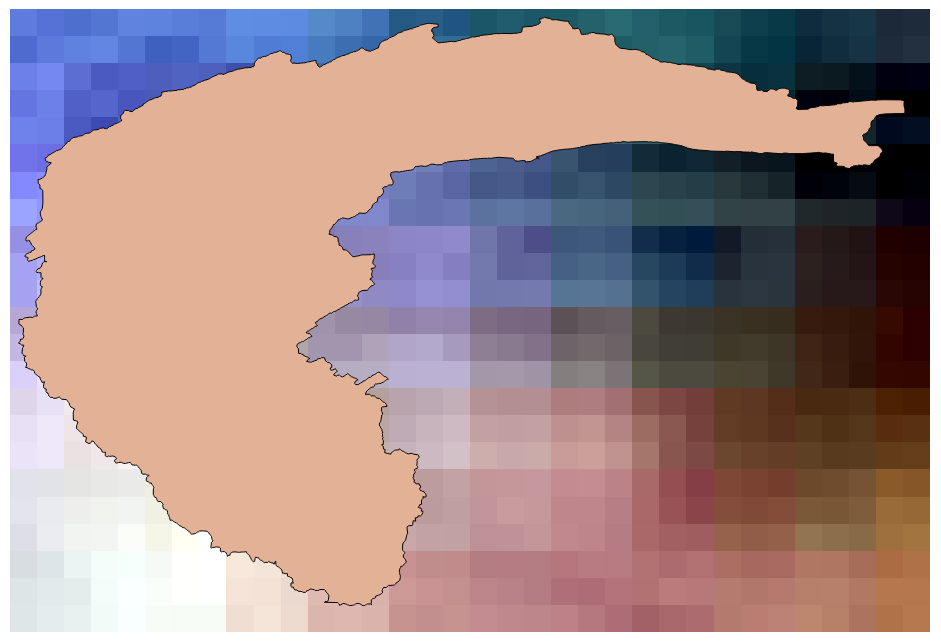

### Cimarron

Run the script to convert the subset data into Envision format:

```bash
bash subset_to_envision.sh Cimarron
```

The conversion took about two minutes. The total size is about 2.1 GB.


Here is the Cimarron shape on top of one of the Cimarron Envision netCDF rasters. Note that there aren't any rows or columns of cells that the shape doesn't intersect.

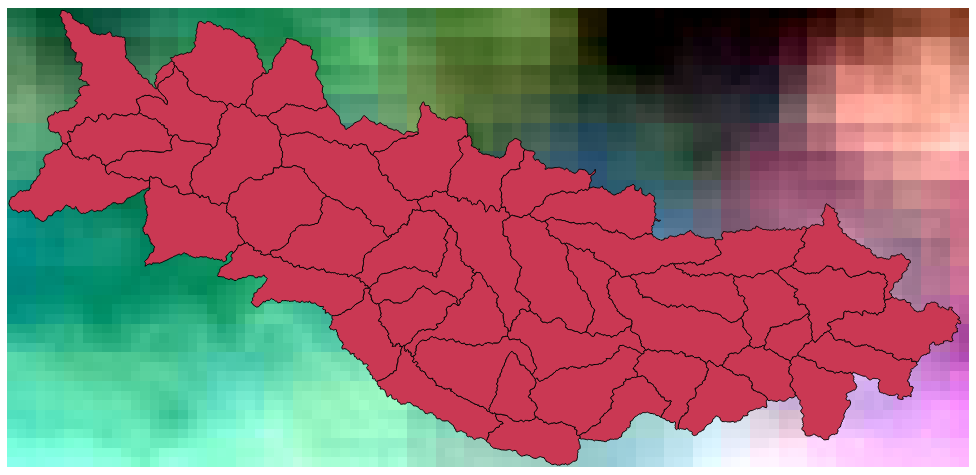

## Converting for SWAT

Converting METDATA to SWAT will be basically the same as converting MACAv2-METDATA to SWAT.

Here are the major steps:

1. Find centroids of watershed sub-polygons
1. Find grid cell closest to centroid
1. Subset data to each grid cell
1. Dump to plain text format for SWAT

Since we've already done MACA and we created netCDF files of relative humidity earlier in during our Envision data conversion, all we need to do is grab the centroids file(s) we already created and make a copy of our python and bash wrapper scripts for extracting point data that we can adjust for METDATA.

```bash
cp ../MACAv2_Derived/Cimarron_centroids.txt ./
cp ../MACAv2_Derived/point_subset.py ./metdata_point_subset.py
cp ../MACAv2_Derived/py_envision_to_swat.sh ./metdata_envision_to_swat.sh
```

The main things we'll need to change in these scripts are:
1. Variable names that appear in file names
1. Overall file name pattern
1. Remove model loops
1. Remove RCP loops


**`metdata_point_subset.py`**

```python
#
# Extract data from netCDF files for use in SWAT.
#
# The netCDF files we're extracting from are the METDATA data with units
# converted for use with Envision. Since Envision and SWAT like the same units,
# we're not doing any unit conversions here like we would if extracting
# directly from the original METDATA netCDFs.
#
# We've also added netcdf files of daily mean relative humidity (which we're
# not using in Envision) into our Envision directories to make things easier 
# on our scripts.
#
# This script is intended to process a geographical subset of METDATA. For each
# climate variable, it reads all the matching files as a time series multi-file
# dataset, then loops over the set of points we want to use as SWAT weather 
# stations and writes an output file containing the data for that point.
#
# This script requires three command line arguments:
# 1. input directory of netCDF files
# 2. output directory where point subsets will be written (must already exist)
# 3. text file of latitude longitude points ("weather stations")
#
#
# Evan Linde, Oklahoma State University, 2017-10-11
#

from netCDF4 import MFDataset
import numpy as np
import sys
import os

# Get inputs and output locations from command line arguments
in_dir = sys.argv[1]
out_dir = sys.argv[2]    # This directory should already exist.
point_file = sys.argv[3] # Each line should have lon and lat separated 
                         # by a space, e.g. "-97.07 36.122".

# Dictionary of climate variables
# Each key is the variable name in the netcdf file name
# Each value is the variable name *inside* the netcdf file
clim_vars = {'pr':'precipitation',
             'rmean':'relative_humidity',
             'srad':'surface_downwelling_shortwave_flux_in_air',
             'tmmx':'air_temperature',
             'tmmn':'air_temperature',
             'vs':'wind_speed'}

# Read the point file into a numpy array
points = np.loadtxt(point_file)


for fvar in clim_vars.keys():
    ncvar = clim_vars[fvar]

    # file names will have the form of fvar_year.nc
    infilename_glob = fvar+'_*.nc' 

    # combine the input directory with filename glob for a full path glob
    infile_glob = os.path.join(in_dir, infilename_glob)

    # read multi-file dataset (all years for our current variable)
    mfd = MFDataset(infile_glob, aggdim='day')

    for p in points:
        # each point p is itself an array in the form of [lon, lat]
        # assign longitude and latitude to variables
        lon,lat = p[0],p[1]

        # base name for output file
        outfilename = '%.3f_%.3f_%s.txt' % (lat, lon, fvar)

        # full path for output file
        outfile = os.path.join(out_dir, outfilename)

        # find the lat and lon indices in the netcdf dataset
        # that are closest to our point
        latindex = np.where(abs(lat - mfd.variables["lat"][:]) < 0.020833)[0][0]
        lonindex = np.where(abs(lon - mfd.variables["lon"][:]) < 0.020833)[0][0]

        # the subset of the netcdf dataset that matches our point
        outdata = mfd.variables[ncvar][:,latindex,lonindex]

        # save the point data to a file
        np.savetxt(outfile, outdata, fmt='%.3f', newline='\r\n', header='19790101', comments='')
```

Just for fun, here's the same script in 5 lines. No comments, no unnecessary whitespace, and no variables explicitly declared unless they have to be. If anyone gives you code like this they must either hate you or be trying way too hard to show off.

**`evil_metdata_point_subset.py`**

```python
import netCDF4,numpy,sys,os
for fvar,ncvar in {'pr':'precipitation','rmean':'relative_humidity','srad':'surface_downwelling_shortwave_flux_in_air','tmmx':'air_temperature','tmmn':'air_temperature','vs':'wind_speed'}.items():
    mfd=netCDF4.MFDataset(os.path.join(sys.argv[1],fvar+'*.nc'),aggdim='day')
    for p in numpy.loadtxt(sys.argv[3]):
        numpy.savetxt(os.path.join(sys.argv[2],'%.3f_%.3f_%s.txt'%(p[1],p[0],fvar)),mfd.variables[ncvar][:,numpy.where(abs(p[1]-mfd.variables["lat"][:])<0.020833)[0][0],numpy.where(abs(p[0]-mfd.variables["lon"][:])<0.020833)[0][0]],fmt='%.3f',newline='\r\n',header='19790101',comments='')
```

**`metdata_envision_to_swat.sh`**

```bash
#!/bin/bash
#
# This script is a wrapper for the python script metdata_point_subset.py 
# which processes a directory containing a geographical subset of the METDATA
# dataset.
#
# This script performs some post-processing to create a SWAT temperature
# file with max and min temperatures.
#
# This script requires the watershed name to be passed in as a command
# line argument.
#

watershed="$1"
centroids_file="${watershed}_centroids.txt"

sourcedir="/data/public/datasets/MACA/METDATA_Derived/${watershed}_Envision"
destdir="/data/public/datasets/MACA/METDATA_Derived/${watershed}_SWAT"
mkdir -p ${destdir}

prefixes=($(awk '{printf("%.3f_%.3f\n",$2,$1)}' ${centroids_file}))

# Set PATH variable so that we use the Anaconda python distribution
PATH=/opt/anaconda3/bin:$PATH

python metdata_point_subset.py ${sourcedir} ${destdir} ${centroids_file}

# The point_subset.py script creates files with a single variable
# SWAT wants a two-column file with tasmax and tasmin separated by commas
for p in ${prefixes[@]}; do
    temperature_file="${destdir}/${p}_temperature.txt"
    paste -d, ${destdir}/${p}_tmm{x,n}.txt > ${temperature_file}
    # Get rid of the duplicated header (remove the comma and everything
    # after it on the first line) and remove mid-line carriage returns 
    # on all lines.
    sed -i '1s/,.*//;s/\r,/,/g' ${temperature_file}
done  # end point prefix loop
```

### Cimarron

Run the script to convert the data into SWAT format:

```bash
bash metdata_envision_to_swat.sh Cimarron
```

This took about 42 seconds. The total size of Cimarron_SWAT is about 28 MB. (The evil version fared the same.)

# Conclusion

## Subsets

We used up a lot of narrative describing selecting proper subsets, particularly in selecting minimum and maximum latitude and longitude values for the `ncks` subset commands. This is a reflection of what we *actually* did and not what we *wish* we had done.

Our final procedure for selecting good subsets, or at least the coordinates to use for our subset commands, was to first pick the coordinate points *closest* to our desired boundary points, then to add or subtract 0.001 (depending on direction) and truncate to three places after the decimal point. This was sufficient to eliminate floating point error and make our subset commands not have such ridiculously long numbers.

## Ensembles

With more attention to the MACA documentation at the beginning, particularly the [GCMs page](https://climate.northwestknowledge.net/MACA/GCMs.php), we would have known that the the strings `r1i1p1` and `r6i1p1` refer to the ensemble used for each model's data and that `r6i1p1` is only used for the CCSM4 model.

With this knowledge we could have added a single line to our MACAv2-METDATA download script and used the same line in the script where we converted the subsets for Envision instead of [globbing](https://en.wikipedia.org/wiki/Glob_(programming)) for the correct file names.

```bash
[[ "${model}" == "CCSM4" ]] && ensemble="r6i1p1" || ensemble="r1i1p1"
```

The line is functionally equivalent to this more readable `if` statement:

```bash
if [[ "${model}" == "CCSM4" ]]; then
    ensemble="r6i1p1"
else
    ensemble="r1i1p1"
fi
```

Explanation for both of these can be found in the `bash` manual under the topics [Conditional Constructs](https://www.gnu.org/software/bash/manual/html_node/Conditional-Constructs.html) and [Bash Conditional Expressions](https://www.gnu.org/software/bash/manual/html_node/Bash-Conditional-Expressions.html).

Additionally, we would have reused the same fully correct loop for the subset step instead of creating the literal list of files.


## Missing Variables

Similarly to how we could have handled the ensembles, we could also have handled the missing `rhsmax` and `rhsmin` variables for the CCSM4 and NorESM1-M models in the download and subset scripts by adding a line like this inside (at the beginning of) the variables (`${wvar}`) loop.

```bash
[[ "${wvar}" == "rhsmax" || "${wvar}" == "rhsmin" ]] && [[ "${model}" == "CCSM4" || "${model}" == "NorESM1-M" ]] && continue
```

The `continue` command causes the loop to jump to the next iteration. With this line added just inside the `${wvar}` loop, we would skip to the next `${wvar}`. This command is explained in the `bash` manual under the topic [Bourne Shell Builtins](https://www.gnu.org/software/bash/manual/html_node/Bourne-Shell-Builtins.html).

The line above is logically equivalent to this slightly more readable code:

```bash
if [[ "${wvar}" == "rhsmax" || "${wvar}" == "rhsmin" ]]; then
    if [[ "${model}" == "CCSM4" || "${model}" == "NorESM1-M" ]]; then
        continue
    fi
fi
```

## Useful Services

We could have used existing services to make subsets rather than downloading entire datasets. If we hadn't had sufficient free space available (about 12.5 TB for the unmodified originals, plus almost 1 TB for subsets and converted data so far), this would have been a necessity rather than a choice. 

If using any of these subset services for METDATA or MACAv2-METDATA and you don't already know the closest coordinates to your shapefile boundary, a good rule of thumb would be to add or subtract 0.05 (depending on direction) from the shapefile's boundary coordinates. This will be sufficient to cover the shapefile and shouldn't get you more than an extra column or row of cells than you need in each direction. (Remember that the cell size is $\frac{1}{24}$ degree; i.e. $0.041\overline{6}$.)


### MACA Data Portal

On MACA's [data portal](https://climate.northwestknowledge.net/MACA/data_portal.php) under the domain option, you can choose a rectangular subset and enter your own coordinates (best to add a little padding as mentioned above). Then download a bash script of `curl` or `wget` commands that you can run to download all the matching files. 

Note that for the time period, you may see the option to choose the full range of years in a single file (for each model, rcp, and variable combination). This may work very well if your subset is small, but may give you trouble with some of the NCO operations. (Some NCO operations require enough available RAM to accommodate the size of the file(s) involved, but I don't recall if this includes anything we've demonstrated here.) More clicking is involved, but it's also possible to choose each of the year blocks instead of a monolithic range, resulting in a subset comparable to what we started with when converting data for Envision.

Setting the domain to a point location allows you to download CSV files that are relatively easy to process for SWAT. The CSV files should look similar to this:

```
#Variables:
#pr(mm):Precipitation
"#Data Extracted for Average over Grid Cell w/ center: 41.9795 Latitude, -110.9807 Longitude (closest value to Latitude:42.0, Longitude:-111.0) "
#Original Data File(s):
#macav2metdata_pr_CCSM4_r6i1p1_rcp85_2091_2095_CONUS_daily.nc 
#===============================================
"yyyy-mm-dd,pr(mm)"
""
yyyy-mm-dd,pr(mm)
2091-01-01,0.000000
2091-01-02,5.652015
2091-01-03,7.541029
2091-01-04,1.810457
...
```

If you need to download multiple points, you could edit the script of `wget` or `curl` commands and replace the literal latitude and longitude values with variables and then loop over your set of points, however as mentioned in the [best practices](https://climate.northwestknowledge.net/MACA/data_portal.php#bestPractices) section, if you have very many points, it may be better to create a rectangular subset and then extract your points from that.

The MACA Data Portal itself serves as a nicer front-end to THREDDS. Links to the THREDDS can be found at https://climate.northwestknowledge.net/MACA/data_catalogs.php.

### THREDDS Catalog for METDATA

Subsets of METDATA are available via THREDDS. To access METDATA via THREDDS, go to the main METDATA page, https://climate.northwestknowledge.net/METDATA/, click the "DOWNLOAD DATA" tab, and then click the link [Aggregated THREDDS Catalog](http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_MET_aggregated_catalog.html).

For each variable you're interested in downloading, follow the link for that variable, then go to the NetcdfSubset link, and do the following:
1. Click the checkbox for the variable
1. On the right side of the screen uncheck the "Disable horizontal subsetting" checkbox
1. Enter the desired latitude and longitude coordinates (with some extra padding, see note above)
1. Choose your time range
1. Click the option to "Add Lat/Lon variables"
1. Choose the output format

You'll notice that a long URL appears at the bottom of the screen. This URL changes with your selections. 

Click the Submit button to start downloading the data you requested.

Or you could copy the URL and download it with a command like this. (Note the quotes around the URL itself.)

```bash
curl -o whatever_you_want_to_call_it.nc 'http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_vs_1979_CurrentYear_CONUS.nc?var=daily_mean_wind_speed&north=38&west=-104&east=-94&south=33&disableProjSubset=on&horizStride=1&time_start=2015-01-01T00%3A00%3A00Z&time_end=2016-12-31T00%3A00%3A00Z&timeStride=1&addLatLon=true&accept=netcdf'
```

The variable names inside the subset files downloaded this way don't all match the directly downloaded files, and they're not not already divided up into yearly chunks, so using this method would require some changes to other parts of our procedure.

### OPeNDAP

Both MACAv2-METDATA and METDATA can be accessed online using [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) at their THREDDS server. This allows you to access the data online without having to download it first. The MACA site provides a [tutorial](https://climate.northwestknowledge.net/MACA/OPENDAP.php) with examples for Python, R, and Matlab.

This would be particularly useful for creating the SWAT files.

## Lessons Learned

Check a subset file to make sure you got what you were aiming for *before* running against the entire dataset. The `ncdump` command is great for this and viewing geographic subsets against your shapefile in QGIS or ArcGIS is even better.

And pay attention to the metadata, both the netCDF metadata and what you find online. It really is helpful; you may even find nice tools that will do useful things for you.